# Tutorial Geomagnetic Field Inversions
This is a tutorial for using the Geomagnetic Field Inversions code written by Frenk Out, Liz van Grinsven, Monika Korte, and Lennart de Groot. This tutorial will guide you through the following process:
1. Loading and Fitting data
2. Starting the model
    1. Initiating a FieldInversion class and add data
    2. Run a time-dependent standard iterative inversion
    3. Plotting results
3. Sweeping through models to find optimal damping parameters (optional)
4. Starting a model for one timestep (optional)
5. Loading data in a Korte et al. format (optional)

### 0. Loading libraries
This tutorial requires, besides geomagnetic_field_inversions, numpy, pandas, pathlib, matplotlib, and cartopy. The geomagnetic_field_inversions code consists of three files:
1. StationData is a class that prepares geomagnetic field data to be inputted in FieldInversion later.
2. FieldInversion is the main class where all calculations happen.
3. plot_tools is a plotting module that helps to create frequently used plots in a easy way.

In [1]:
import numpy as np
# Necessary for loading excel or csv files
import pandas as pd
# Necessary for correct path handling
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
# Cartopy is only required for plotting world maps
import cartopy.crs as ccrs

# Our code
from geomagnetic_field_inversions import plot_tools, StationData, FieldInversion

## 1. Loading and Fitting data
#### Set-up
We will now proceed to loading and fitting the data. This is required to run the inversion later. The basic input for adding and fitting the data is latitude (between -90 and 90 degrees) and longitude (between -180 and 180 degrees) of each sample location. After the class is initiated, data can be added. This data can be inclination (degrees), declination (degrees), or intensity data (nT), but also X (nT), Y (nT), Z (nT), or H (nT) magnetic data.

We start by loading `multi_station.xlsx` and extract the latitude and longitude of the first station

In [2]:
# Set a path to load and save files
# path should be like: .../geomagnetic_field_inversions/doc
path = Path().absolute()
# location of our 'mock' dataset
excel = pd.ExcelFile(path / 'multi_station.xlsx')
# read the latitude and longitude of first station
sheet = pd.read_excel(excel, 'Station 1')
lat, lon = sheet.iloc[0, [6, 7]]
print(lat, lon)

-47.1 5.9


#### *StationData and add_data*
Now that we have obtained the latitude and longitude, we can proceed to adding and fitting the intensity, declination, and inclination datasets. All data belonging to the same location can be added to the same class. First we initiate a class for the station using its latitude and longitude (and optionally a name). After that, we add data belonging to that station separately (from the spreadsheet) add expected error and finally fit a line through it.

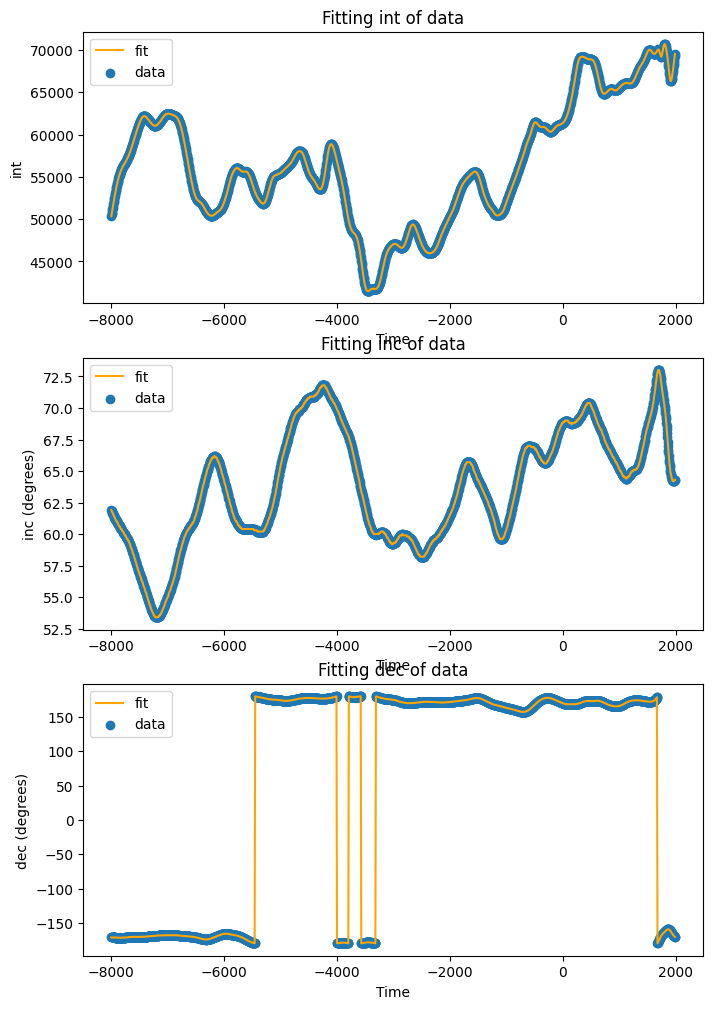

In [3]:
# Start by initializing a new class using latitude and longitude of the station
station = StationData(lat, lon, name='Station 1')

# We inputted time as kiloyears, so our timefactor is 1
station.add_data('int', (sheet.iloc[:, [0, 1]].dropna().T.values.tolist()), 1, error=[100])
station.add_data('inc', (sheet.iloc[:, [2, 3]].dropna().T.values.tolist()), 1, error=[1])
station.add_data('dec', (sheet.iloc[:, [4, 5]].dropna().T.values.tolist()), 1, error=[1])

# The fitting method fits a line through the data points
# By calling plot_tools.plot_station we can see the resulting graphs
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
station.fitting()
plot_tools.plot_station(axes, station)
plt.show()

# add the station to our list of stations, which will come in handy later.
stationlist = []
stationlist.append(station)

If we would not be happy with the datafit, we could decide to use a different fitting: e.g. polyfit or univariatespline. However, linear fitting is fine for all of our stations. Now we will also fit the other stations, but without showing all the output and in a more efficient (programming) way.

In [4]:
# Now we fit the rest, but do not show the output
# By calling plot_tools.plot_station like above you can observe the plots
for nr in range(2, 37):
    sheet = pd.read_excel(excel, sheet_name=f'Station {nr}')
    lat, lon = sheet.iloc[0, [6, 7]]
    station = StationData(lat, lon, name=f'Station {nr}')
    station.add_data('int', (sheet.iloc[:, [0, 1]].dropna().T.values.tolist()), 1, error=[100])
    station.add_data('inc', (sheet.iloc[:, [2, 3]].dropna().T.values.tolist()), 1, error=[1])
    station.add_data('dec', (sheet.iloc[:, [4, 5]].dropna().T.values.tolist()), 1, error=[1])
    station.fitting()
    stationlist.append(station)

Longitude changed from -74.40 to 285.60
Longitude changed from -91.40 to 268.60
Longitude changed from -73.10 to 286.90
Longitude changed from -57.60 to 302.40
Longitude changed from -57.60 to 302.40
Longitude changed from -10.20 to 349.80
Longitude changed from -10.40 to 349.60
Longitude changed from -9.90 to 350.10
Longitude changed from -24.20 to 335.80
Longitude changed from -45.60 to 314.40
Longitude changed from -48.50 to 311.50
Longitude changed from -22.00 to 338.00
Longitude changed from -23.60 to 336.40
Longitude changed from -24.10 to 335.90
Longitude changed from -37.50 to 322.50
Longitude changed from -37.40 to 322.60
Longitude changed from -4.00 to 356.00
Longitude changed from -21.80 to 338.20
Longitude changed from -64.70 to 295.30


Our data is now ready to be used in the next step
- Note how the longitude is automatically recasted into a range between -180 degrees and +180 degrees

## 2. Starting the model
### 2. Initiate a FieldInversion class and add data
#### *FieldInversion*
The `FieldInversion`-class is the 'location' where we will perform all calculations. We start a FieldInversion class by calling
- `MyInstance = FieldInversion(time_array=np.linspace(-8000, 1990, 252), maxdegree=10, verbose=True)` 

The time_array contains the timesteps over which we want to invert our data; we set our maximum spherical degree to 10; the verbosity flag helps us to understand what is going on in the code.

More parameters can be changed, but we will not do that for now.

&rarr; For more info about other parameters of this class, type:
`FieldInversion?`

In [5]:
# input modeled time array; from 3000 to 17000 with steps of 100 yr
test_inv = FieldInversion(time_array = np.linspace(-8000, 1990, 252), maxdegree=10, verbose=True)

#### *add_data*
After we have initiated the `FieldInversion`-class, we add our data by simply calling the `add_data`-method and adding the fitted classes from the previous step. All data errors are linearly interpolated as default option.

In [6]:
for station in stationlist:
    test_inv.add_data(station)

Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 1 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 2 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 3 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 4 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 5 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 6 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordi

The output tells us that the different datatypes are successfully added to the `FieldInversion`-class. Additionally, the coordinates of the sample stations are translated into a geocentric reference frame, since they are given in a geodetic reference frame.

### B. Run a time-dependent standard iterative inversion
After we have set up the class, we can proceed to the geomagnetic field inversion.
#### *prepare_inversion*
First we have to prepare all matrices before execution. For that purpose we need two parameters:
- spatial_dict: a dictionary containing all parameters for spatial damping
- temporal_dict: a dictionary containing all parameters for temporal damping

Spatial damping enforces that higher order Gauss coefficients do not become too large, while temporal damping enforces a smoothness condition on the individual Gauss coefficients through time.

We will use 'Gubbins'-like (constrain by Ohmic heating) spatial damping with a damping factor of 5e-13. For the temporal damping we will use 'Br2cmb' (minimizes the magnetic field flux through the core-mantle boundary) with a damping factor of 1e-1. For more info on the implemented damping types, please have a look at `damping_modules/damp_types.py`.

For illustrative purposes, we ahve set the damping factors already. Normally you would have to investigate which combination of damping parameters is best (see section 3). The higher the damping factor, the smoother your model parameters becomes, but the higher the data residual will be.

In [7]:
spat_dict = {"df": 5e-13, "damp_type": 'Gubbins', "ddt": 0, "damp_dipole": False}
temp_dict = {"df": 1e-1, "damp_type": 'Br2cmb', "ddt": 2, "damp_dipole": True}
test_inv.prepare_inversion(spat_dict=spat_dict, temp_dict=temp_dict)

The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
Calculating Schmidt polynomials and Fréchet coefficients
Calculating spatial damping matrix
Calculating temporal damping matrix
Calculations finished


- Note how we got a warning that we are trying to solve more variables than we have datapoints per timestep. The inversion will still work, but pay attention to the credibility of especially the higher order terms.

#### *run_inversion*
Now we have prepared everything for the inversion. We can now proceed to starting the iterative inversion by using the `run_inversion`-method. This method requires at least a starting model. We will use a starting model with where only $g_1^0$ has a value of 30000.

we also set the maximum amount of iterations to 30, but always check whether the model converged sufficiently (see plot_residuals). Additionally, you can impose rejection criteria here by providing a numpy array to the `rej_crits`-parameter. This array should be at least 7 items long and contains, in order, the rejection criteria for magnetic X-data, Y-data, Z-data, H-data, intensity data, inclination data, and declination data. Here, we do not use rejection criteria. Additionally, by providing a path you could store the normal matrices to construct a covariance matrix (and obtain standard deviations) later.

In [8]:
# our starting model should be as long as the number of gaussian coefficients up to degree 10, i.e. 120 coefficients.
x0 = np.zeros(120)
# you could also make use of the attribute _nm_total to do this automatically:
# x0 = np.zeros(test_inv._nm_total)
x0[0] = 30000
test_inv.run_inversion(x0, max_iter=30)

Setting up starting model
Start iteration 1
Create forward and residual observations
Start formation time dependent matrices
Prepare and solve equations
Residual is 45.05
Start iteration 2
Create forward and residual observations
Start formation time dependent matrices
Prepare and solve equations
Residual is 5.52
Start iteration 3
Create forward and residual observations
Start formation time dependent matrices
Prepare and solve equations
Residual is 3.90
Start iteration 4
Create forward and residual observations
Start formation time dependent matrices
Prepare and solve equations
Residual is 3.88
Start iteration 5
Create forward and residual observations
Start formation time dependent matrices
Prepare and solve equations
Residual is 3.88
Start iteration 6
Create forward and residual observations
Start formation time dependent matrices
Prepare and solve equations
Residual is 3.88
Start iteration 7
Create forward and residual observations
Start formation time dependent matrices
Prepare an

After each iteration, the rms residual is shown and how many datapoins are rejected. After 3 iterations the residual does not change much.

#### *save_spherical_coefficients*
We will now proceed to saving our final coefficients by inputting a path and name to save our files; we save the residuals by setting `save_residual=True`. This will create a *Tutorial_residual.csv*-file containing all residuals after each timestep. Additionally, we save the final Gauss coefficients of the final iteration, per timestep, unsplined. The gaussian coefficients are stored degree-wise, so: $g_1^0$, $g_1^1$, $h_1^1$, $g_2^0$, $g_2^1$, $h_2^1$, $g_2^2$, $h_2^2$, etc ...

In [9]:
test_inv.save_coefficients(path / 'output', file_name='Tutorial', save_residual=True)

### C. Plotting Results
After running the inversion, we will obtain plots of the results to investigate what is going on in our model. For that purpose, we will plot residuals, powerspectra, coefficients, and magnetic field values through time.

#### residuals plots
by calling `plot_tools.plot_residual` we can easily create a plot that shows the residuals of the various datatypes per iteration. The figure shows in this case that after 3-4 iterations the residual seems stable.

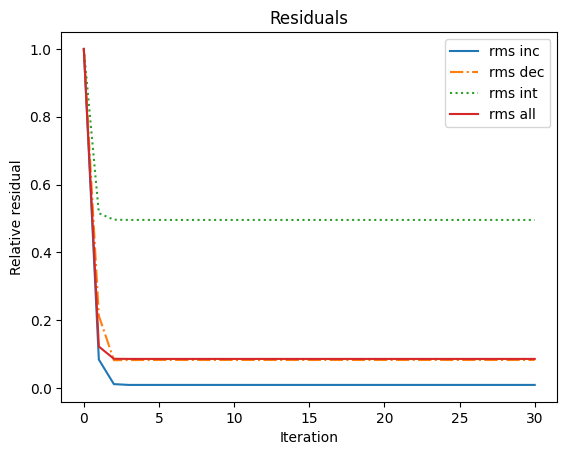

In [10]:
# We start by plotting the rms of various types per iteration
# start a figure
fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative residual')
# make a call to the plotting library, input ax and our FieldInversion instance
ax = plot_tools.plot_residuals(ax, test_inv)
ax.legend(loc='upper right')
plt.show()

#### powerspectra
The `plot_tools.plot_spectrum` allows the plotting of the powerspectrum and secular variation of the gaussian coefficients. The default option is to plot the energy 'stored' in each degree. If the `cmb`-parameter is set to True, the two plots show the powerspectrum and secular variation at the core mantle boundary.

It is also possible to plot the powerspectrum and secular variation at a different time interval.

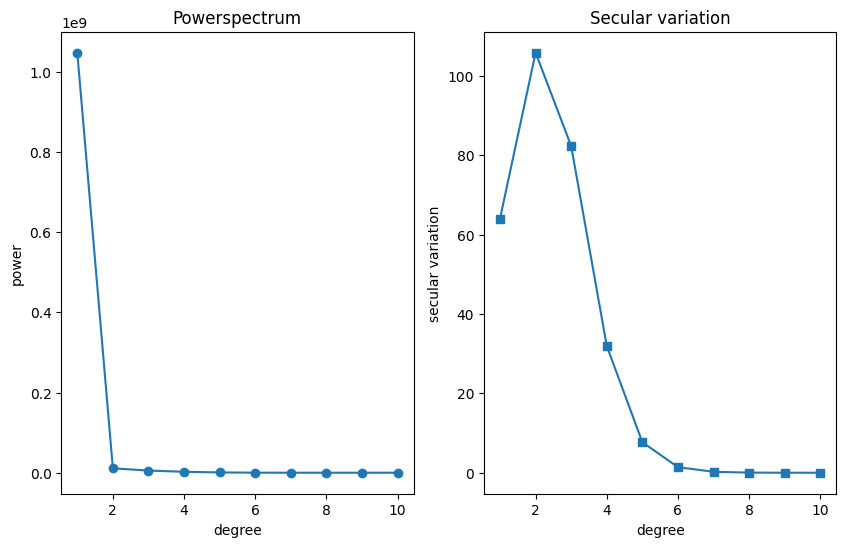

In [11]:
# start figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title('Powerspectrum')
axes[0].set_xlabel('Spherical degree l')
axes[0].set_ylabel('Power')
axes[1].set_title('Secular variation')
axes[1].set_xlabel('Spherical degree l')
axes[1].set_ylabel('Secular variation')
# make a call to the plotting library
axes = plot_tools.plot_spectrum(axes, test_inv)
plt.show()

#### damping norms
The `plot_tools.plot_dampnorm` enables the plotting of the spatial/temporal damping norm through time. First we plot the spatial damping norm, then the temporal damping norm is plotted by setting `spatial=False`.

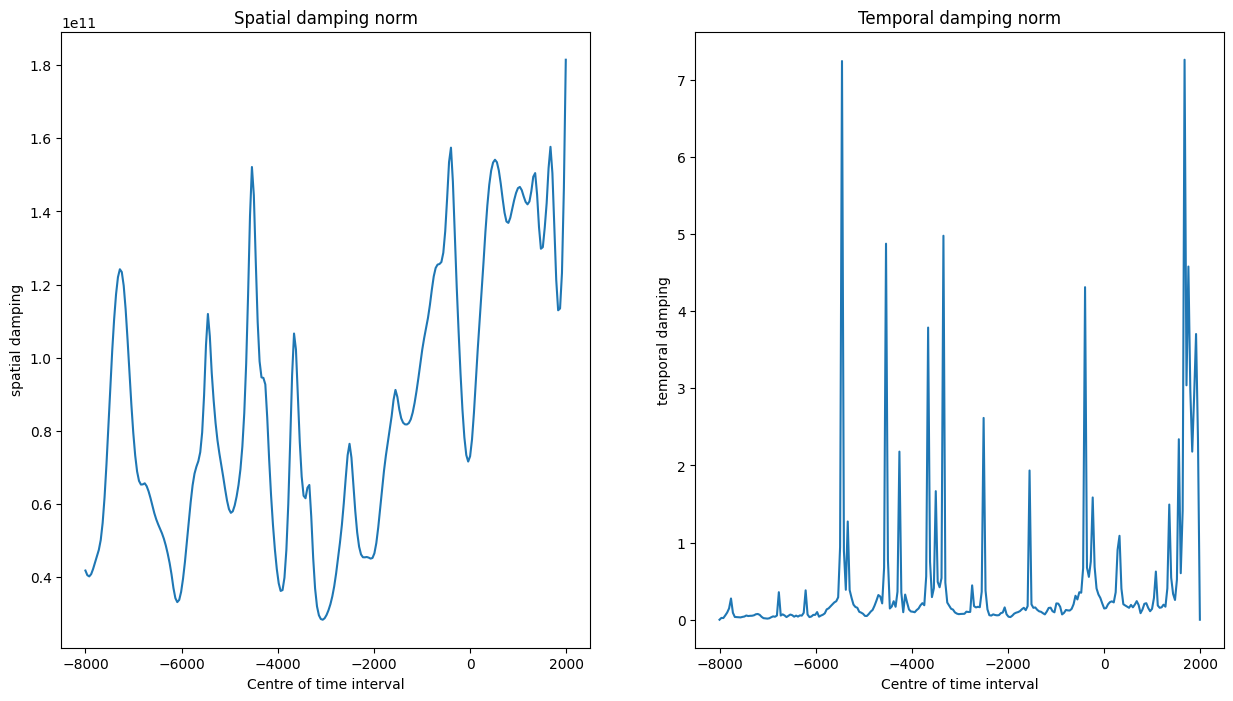

In [15]:
# start figure
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].set_title('Spatial damping norm')
axes[0] = plot_tools.plot_dampnorm(axes[0], test_inv)
axes[1].set_title('Temporal damping norm')
axes[1] = plot_tools.plot_dampnorm(axes[1], test_inv, spatial=False)
plt.show()

#### Gauss coefficients
By using `plot_tools.plot_coeff` we can plot the gaussian coefficients through time. It plots all gaussian coefficients of the same degree at once, but we could also decide to define yourself which coefficients to plot by setting `index` (see `plot_tools.plot_coeff`). It defaults to using the coefficients calculated in the last iteration, but we could choose otherwise by setting `it_time` to something else than -1.

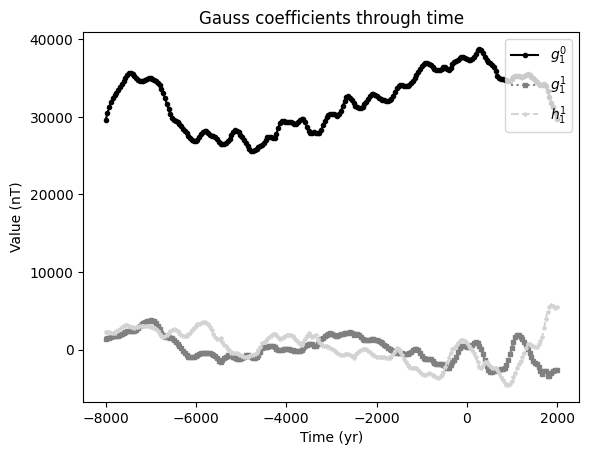

In [12]:
fig, ax = plt.subplots()
ax.set_title('Gauss coefficients through time')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Value (nT)')
# we only want to plot gaussian coefficients of degree 1
ax = plot_tools.plot_coeff(ax, test_inv, degree=1)
ax.legend(loc='upper right')
plt.show()

We can also plot the Gauss coefficients per iteration, in order to do that we set `plot_iter=True`:

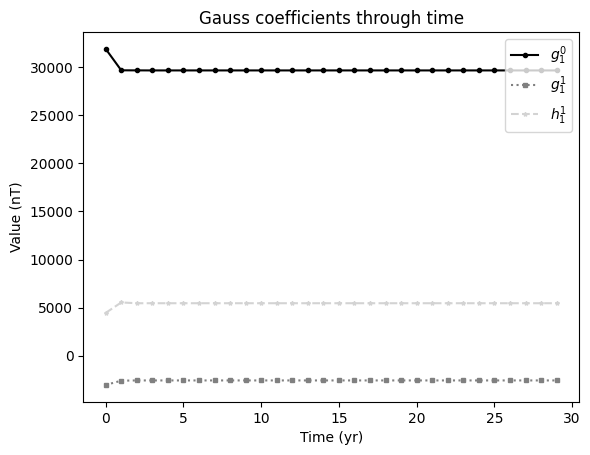

In [13]:
fig, ax = plt.subplots()
ax.set_title('Gauss coefficients through time')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Value (nT)')
# we only want to plot gaussian coefficients of degree 1
ax = plot_tools.plot_coeff(ax, test_inv, degree=1, plot_iter=True)
ax.legend(loc='upper right')
plt.show()

Already after 3 iterations, the Gauss coefficients are stable

#### compare model to data
After running the model, it would be helpful to see how well the data is fitted in our model. `plot_tools.compare_loc` was created for this purpose. By inputting the dataclass (see section 1), the `FieldInversion`-instance, and a matplotlib axis into this function we can observe the fit. (Red zones would correspond to rejected data; not visble now since we did not impose rejection criteria)

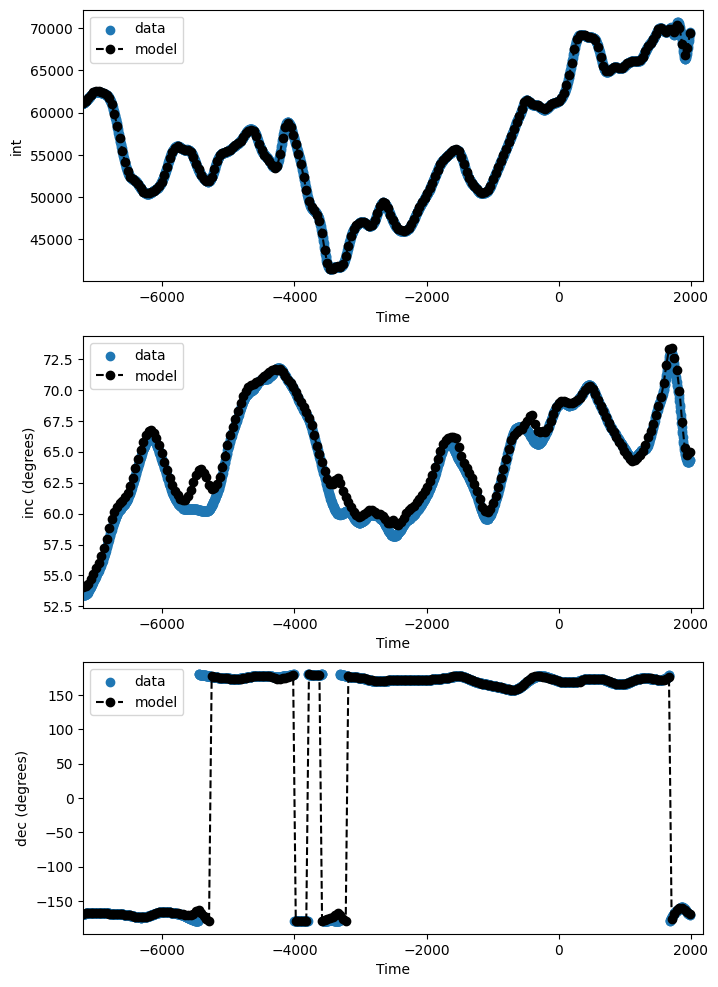

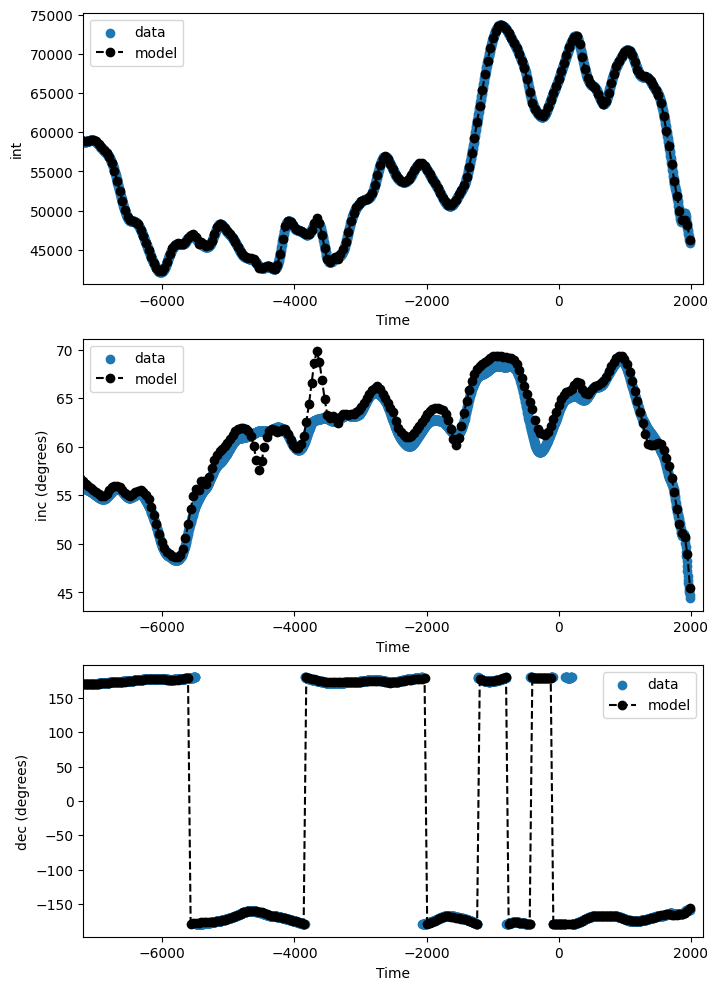

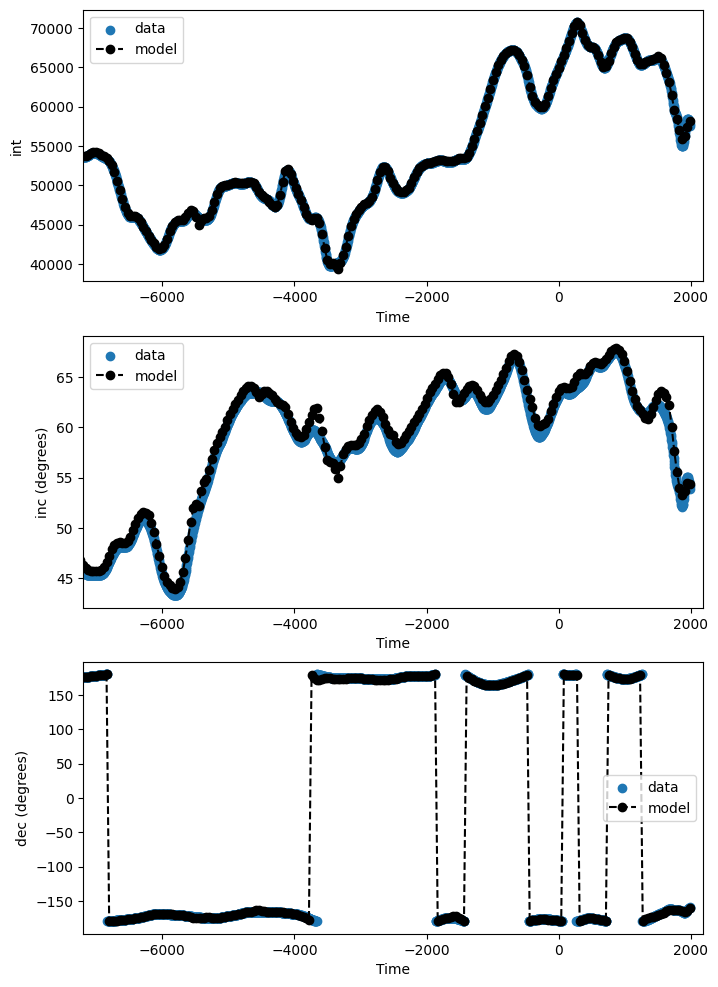

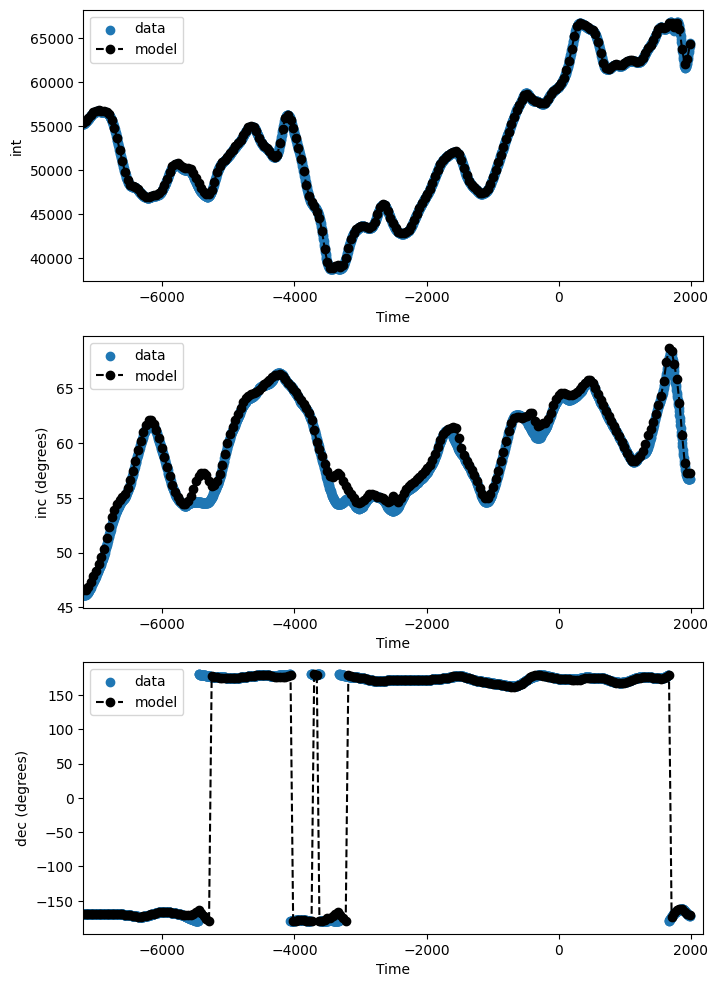

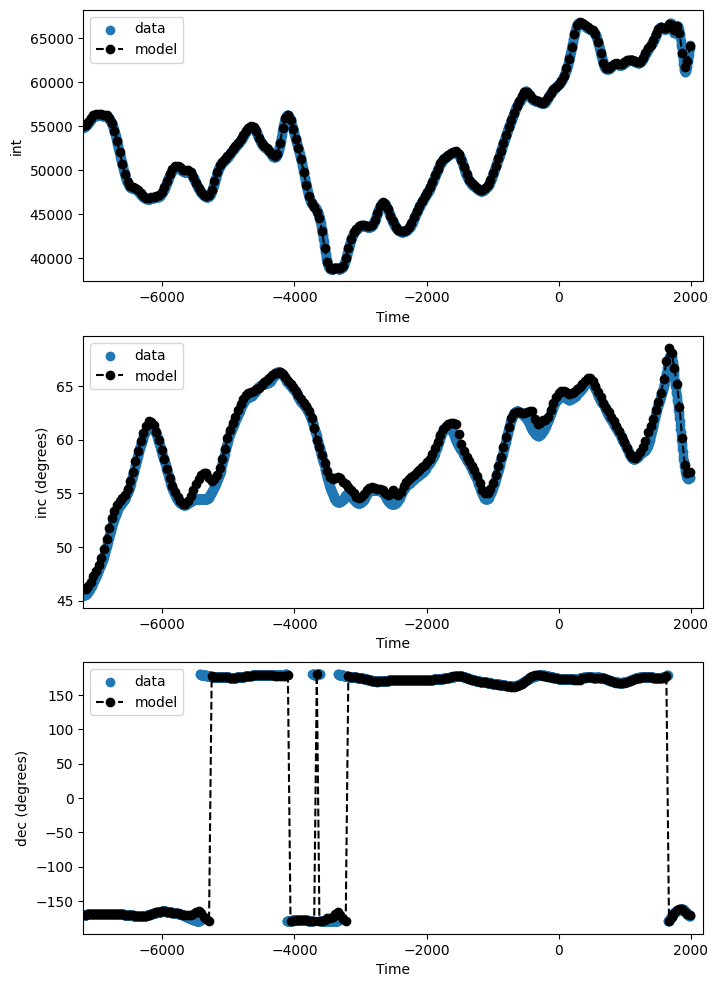

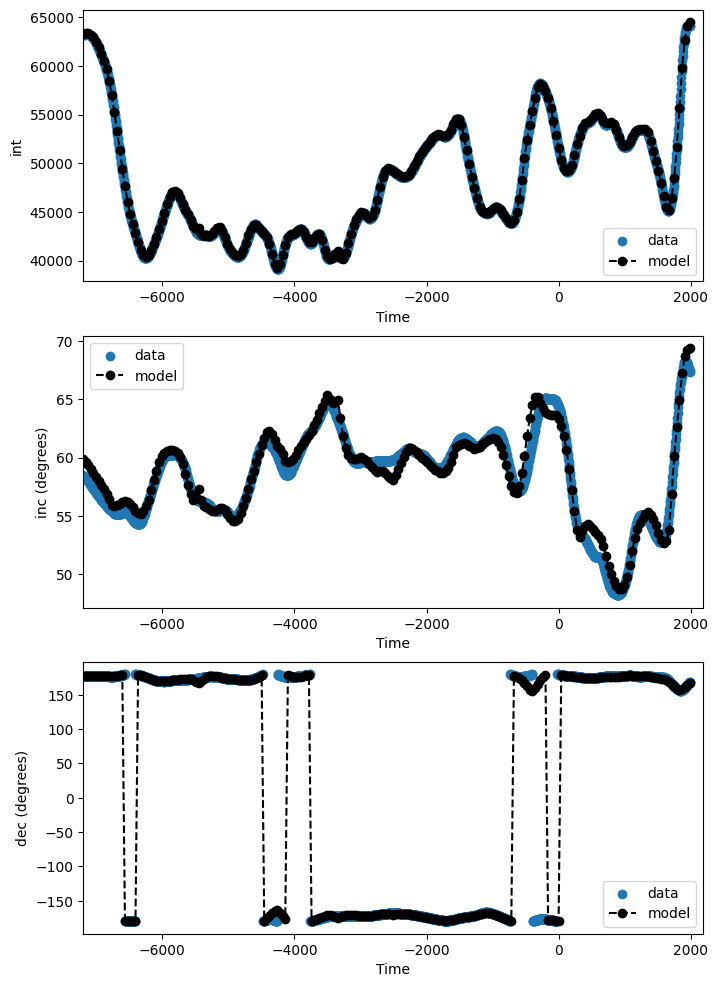

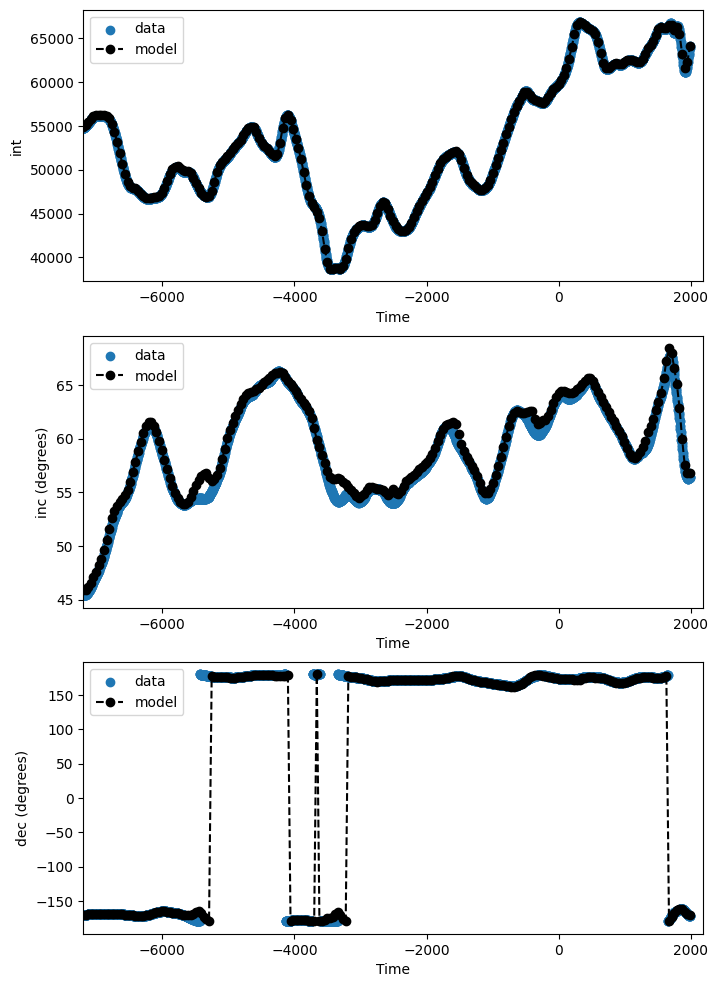

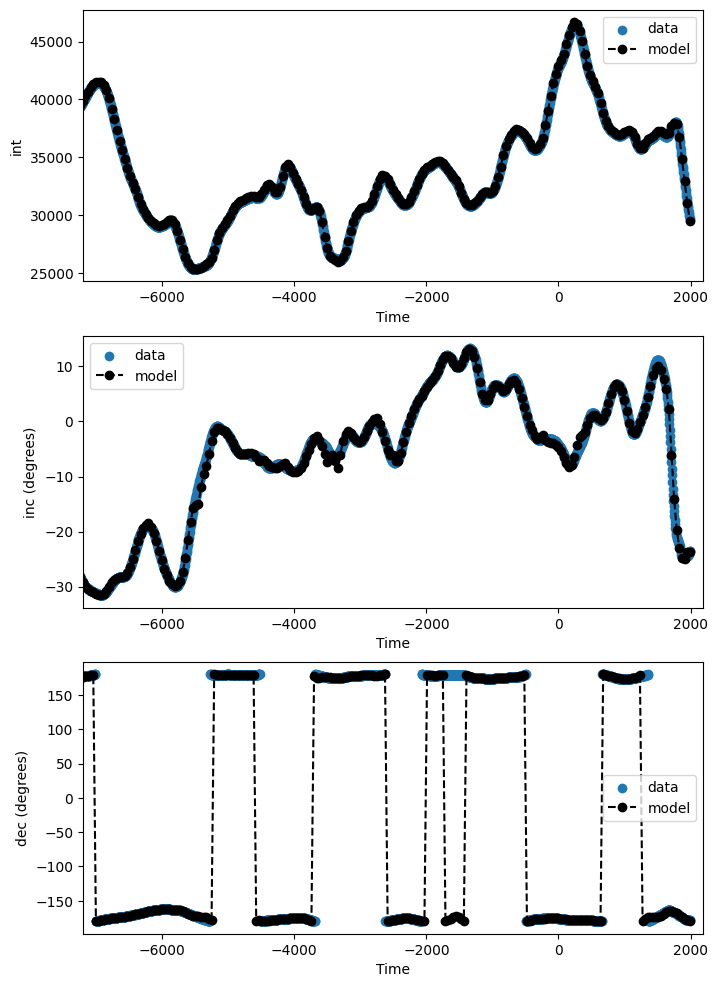

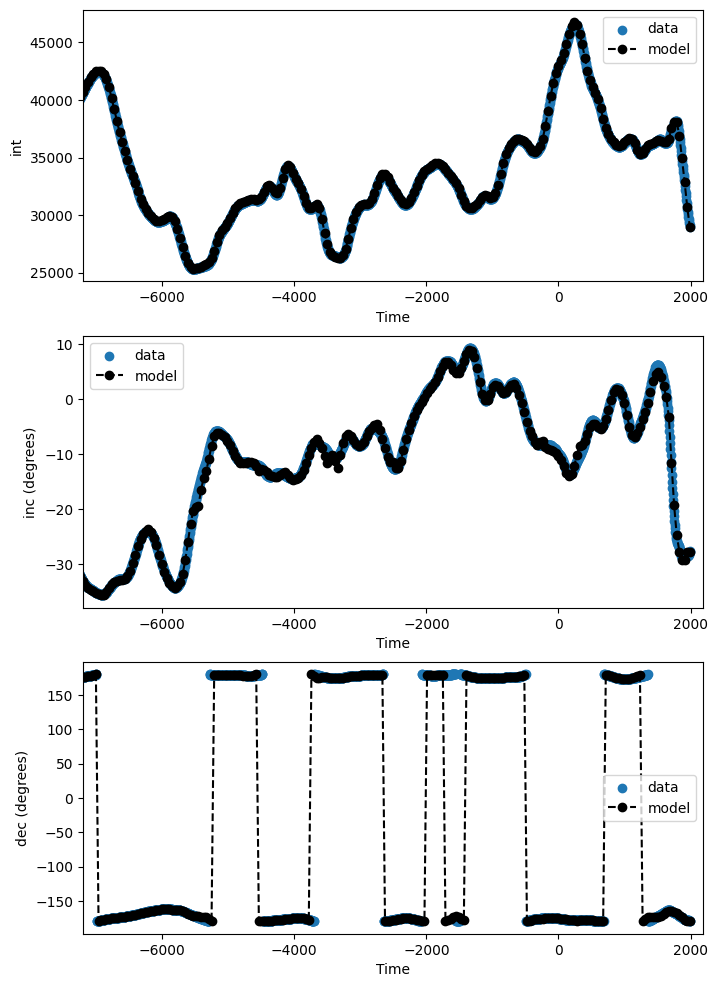

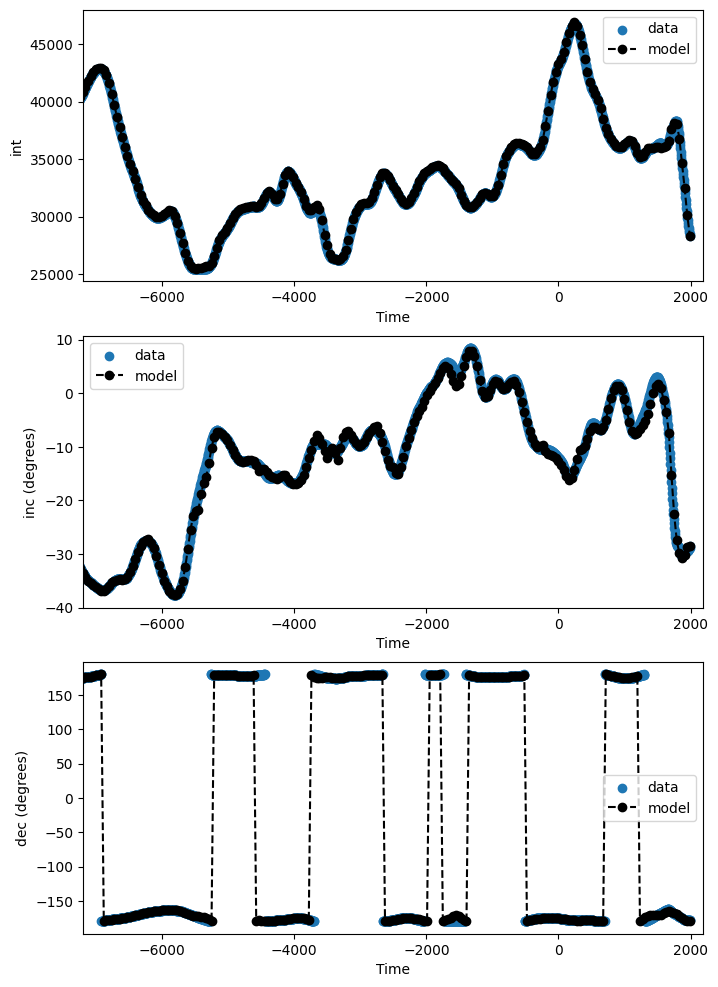

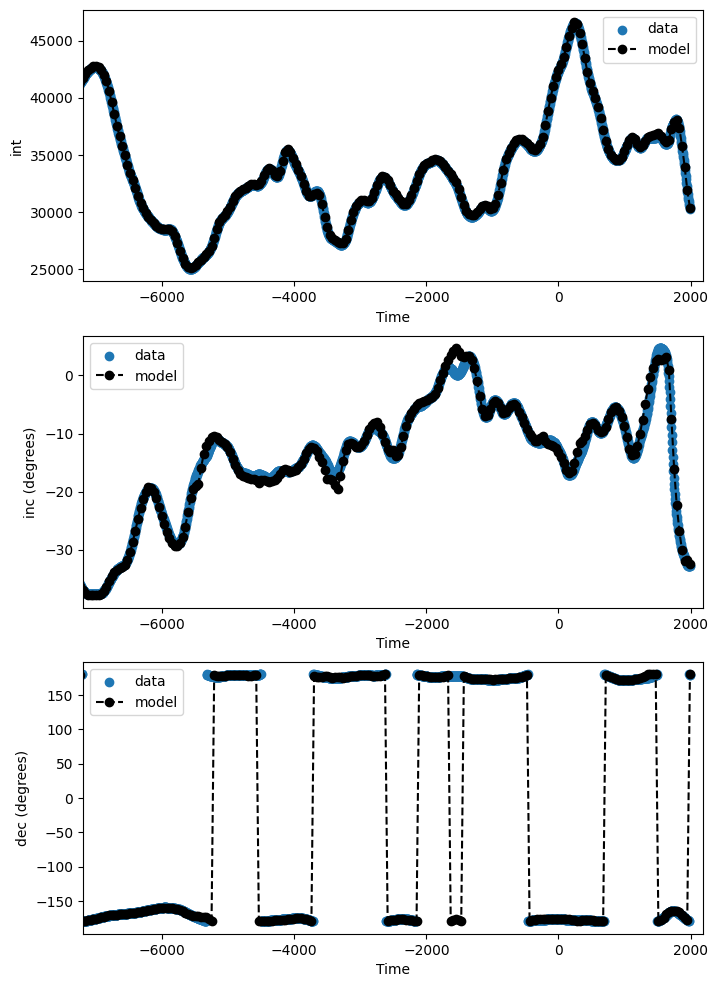

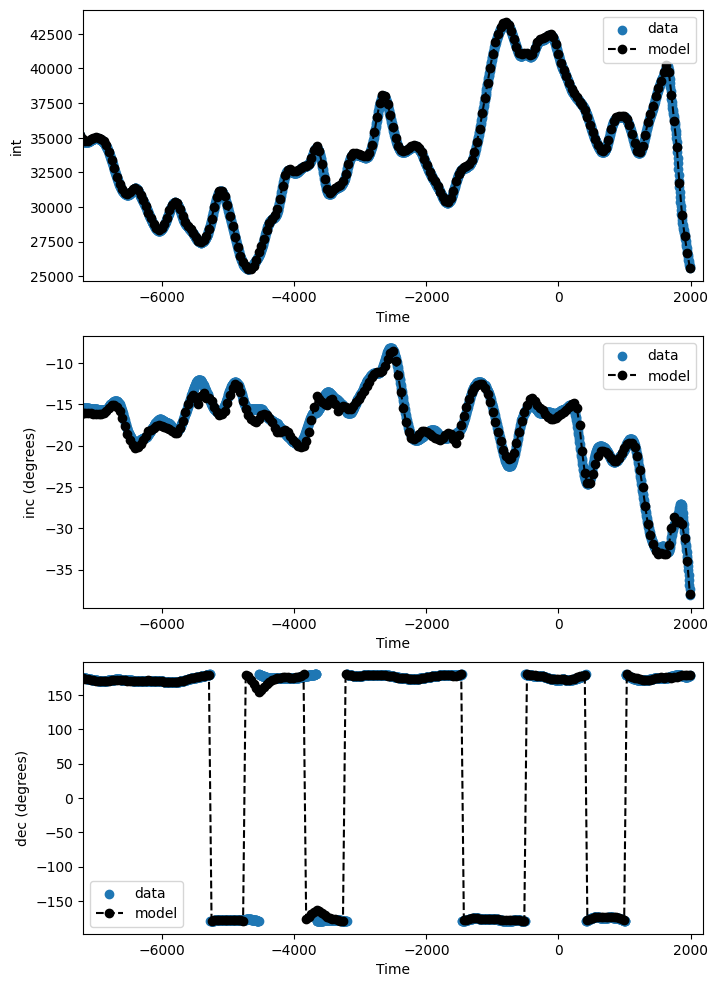

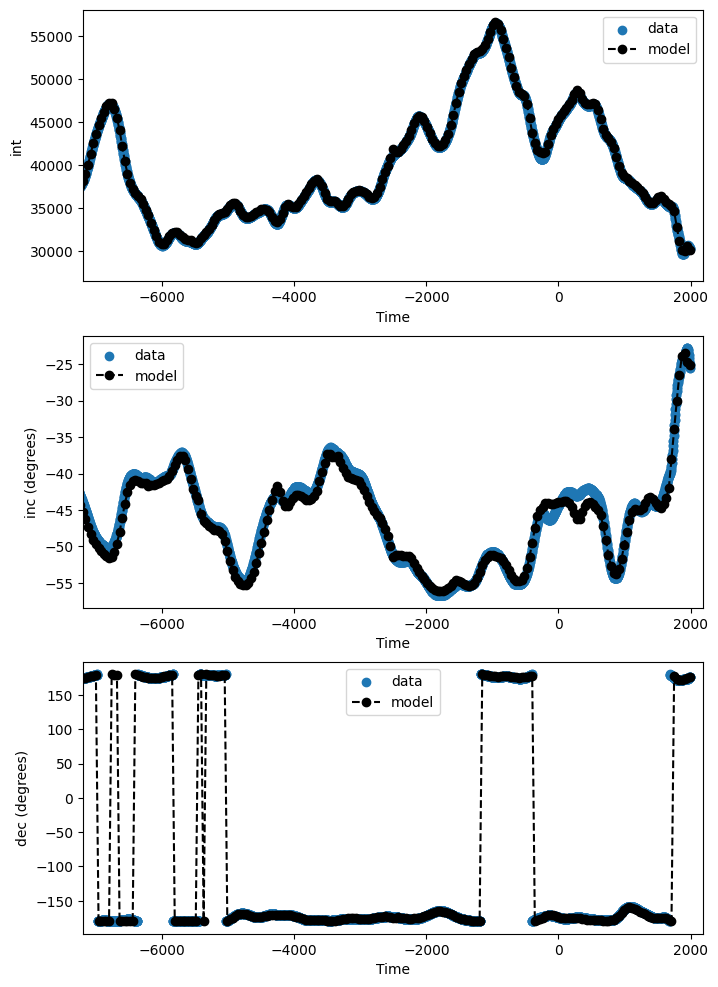

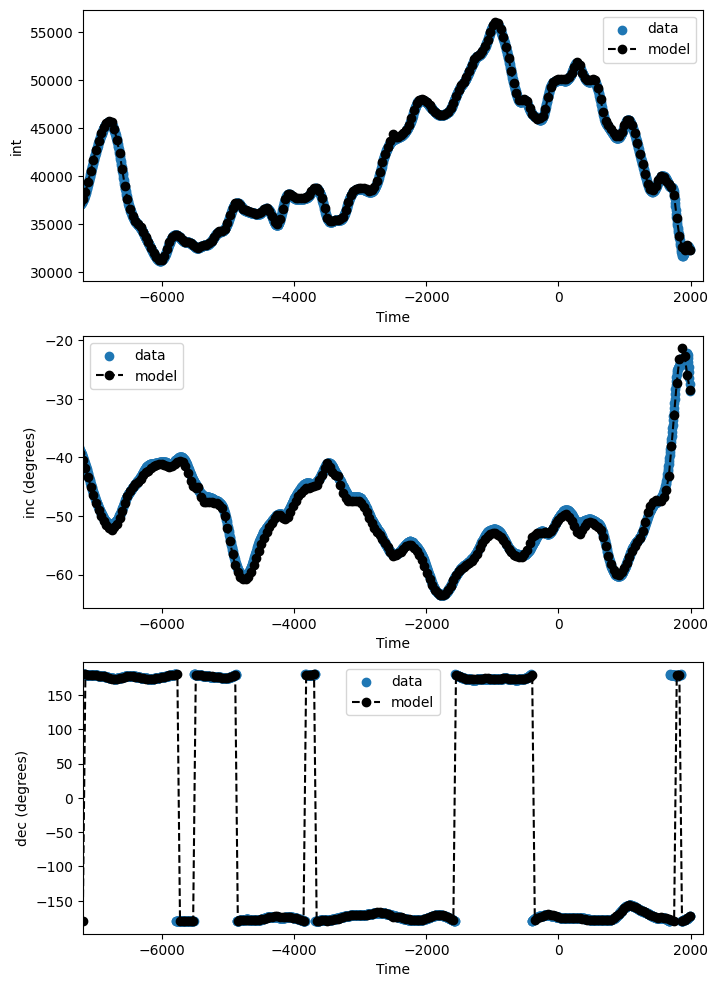

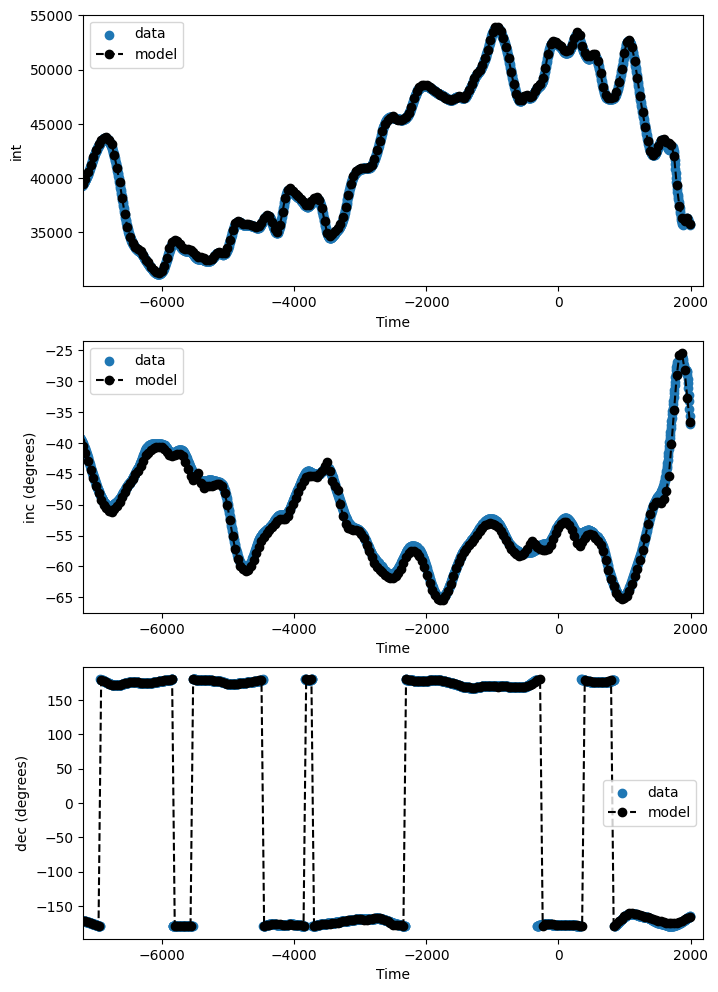

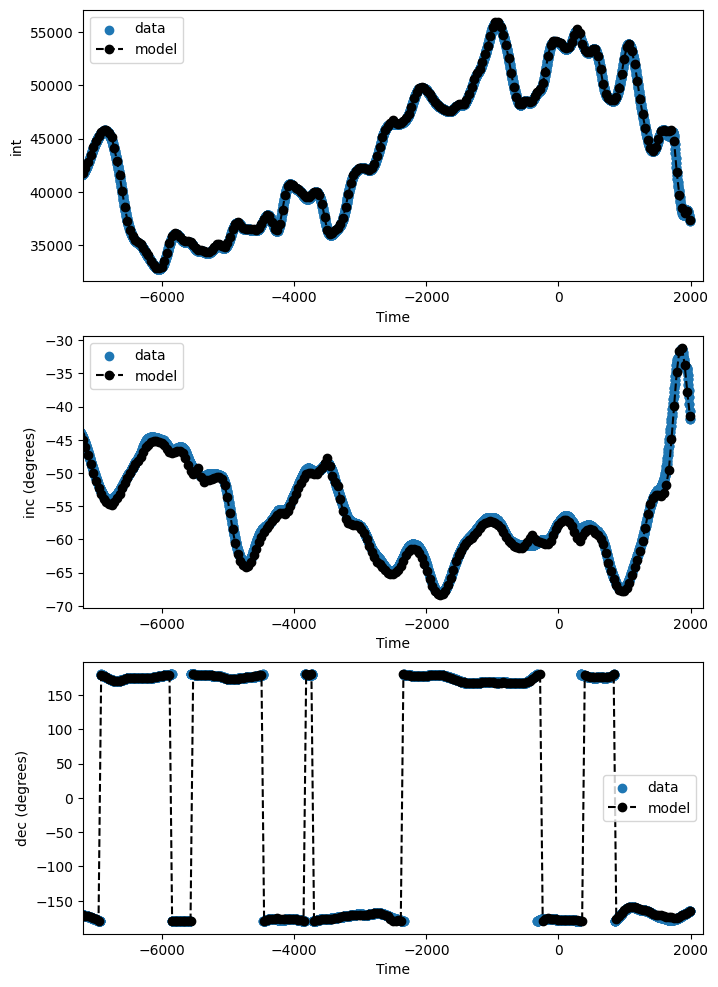

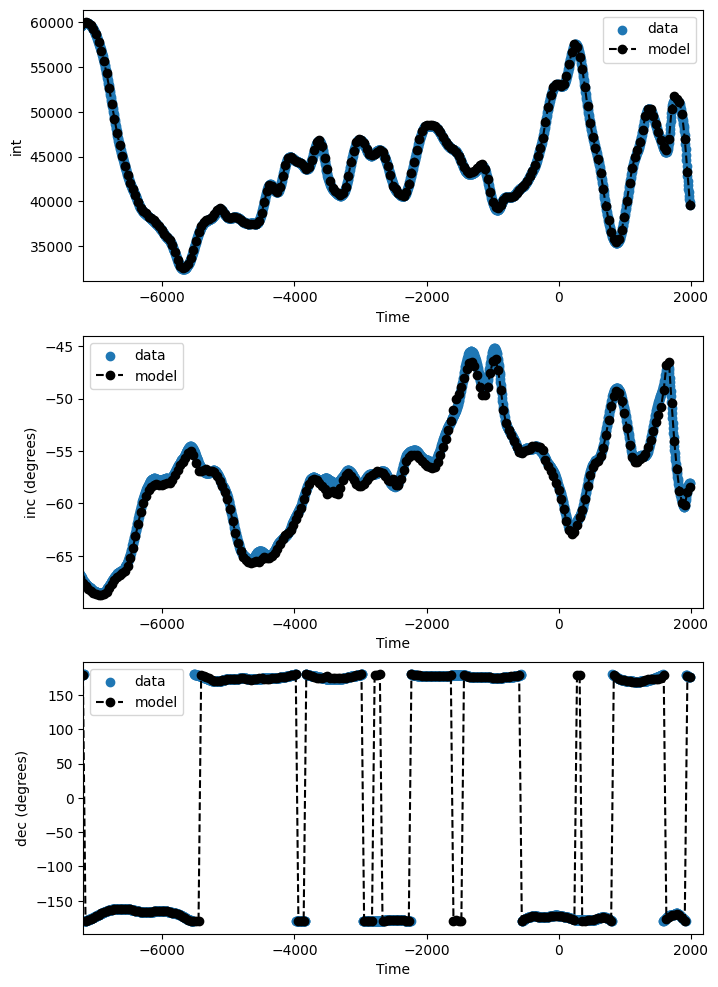

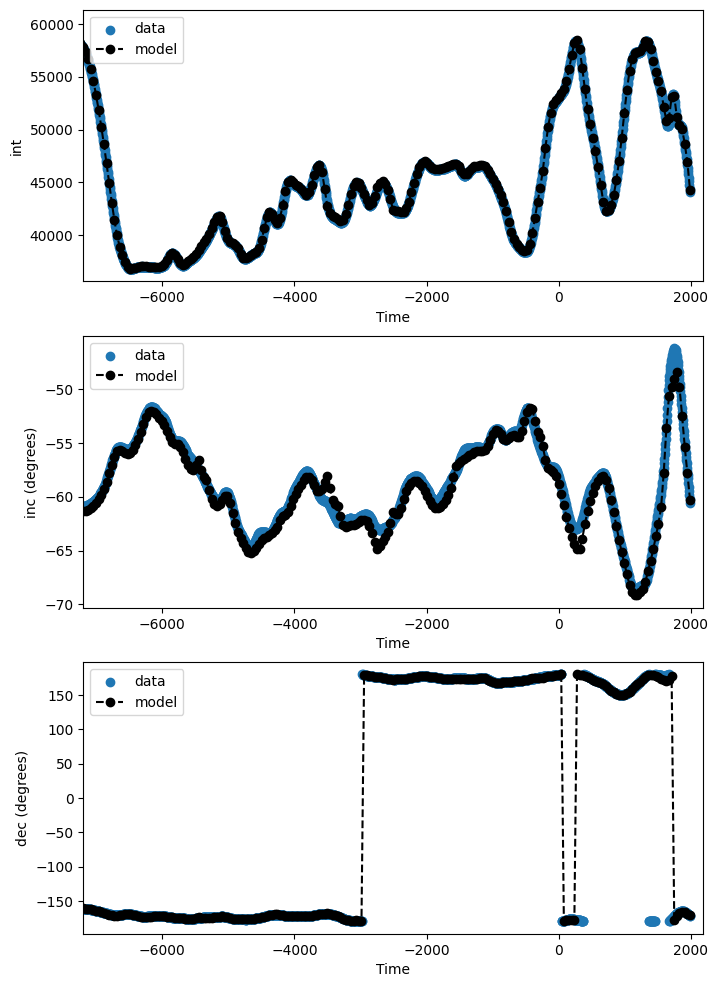

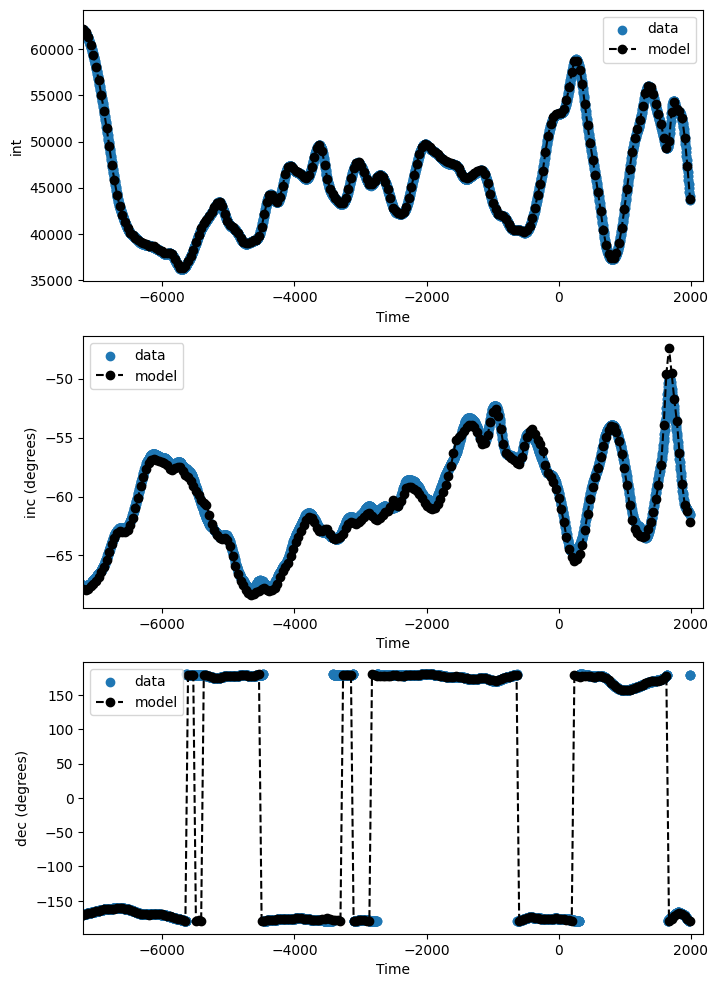

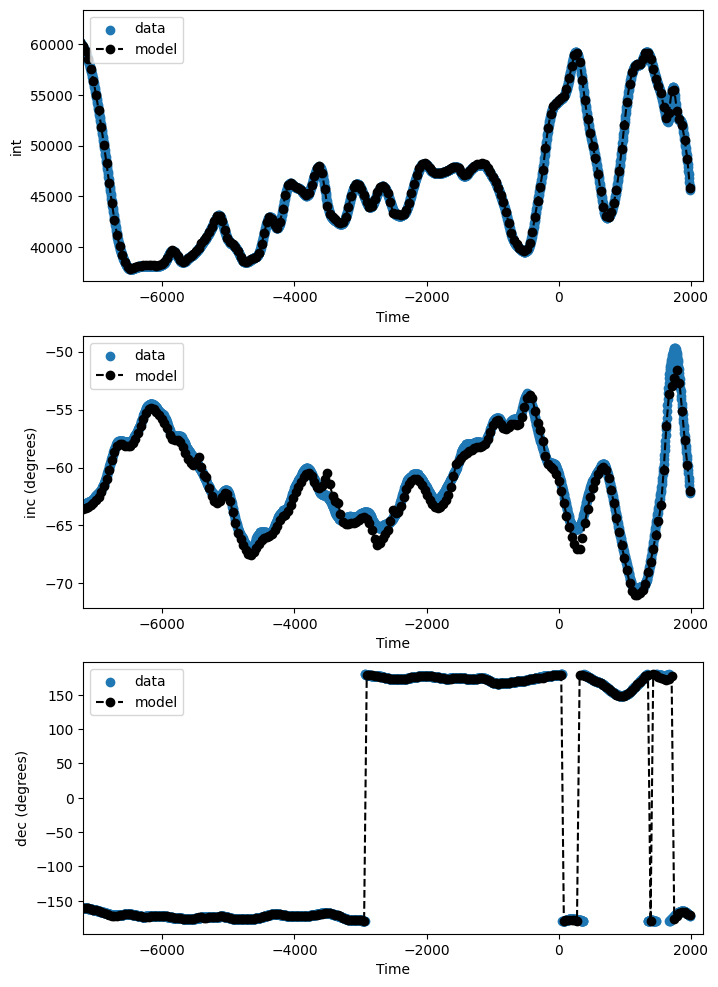

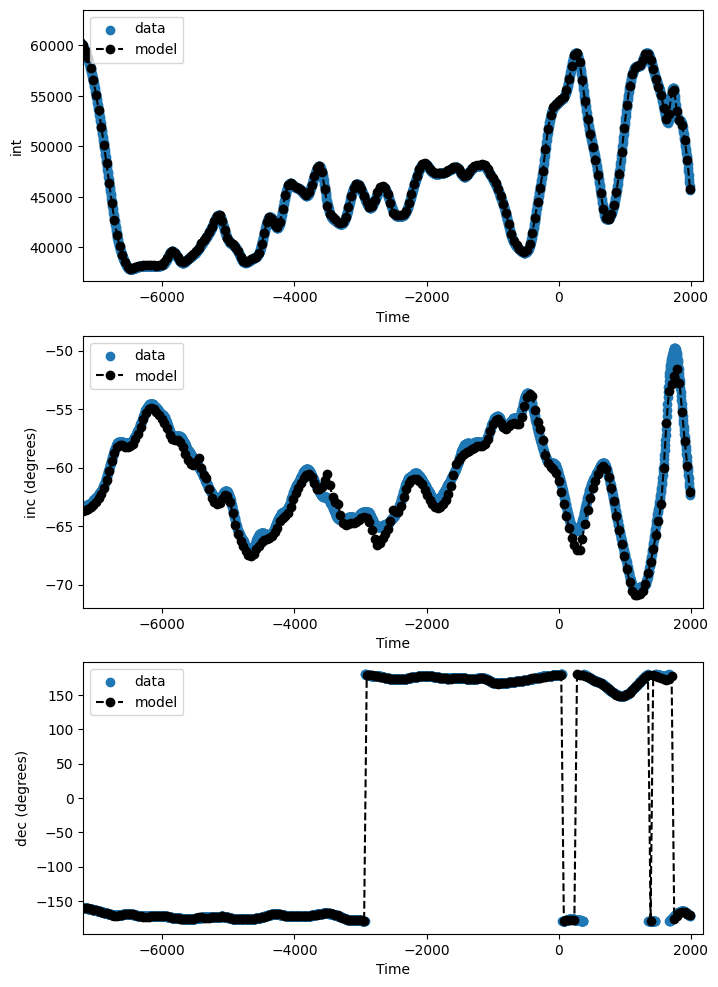

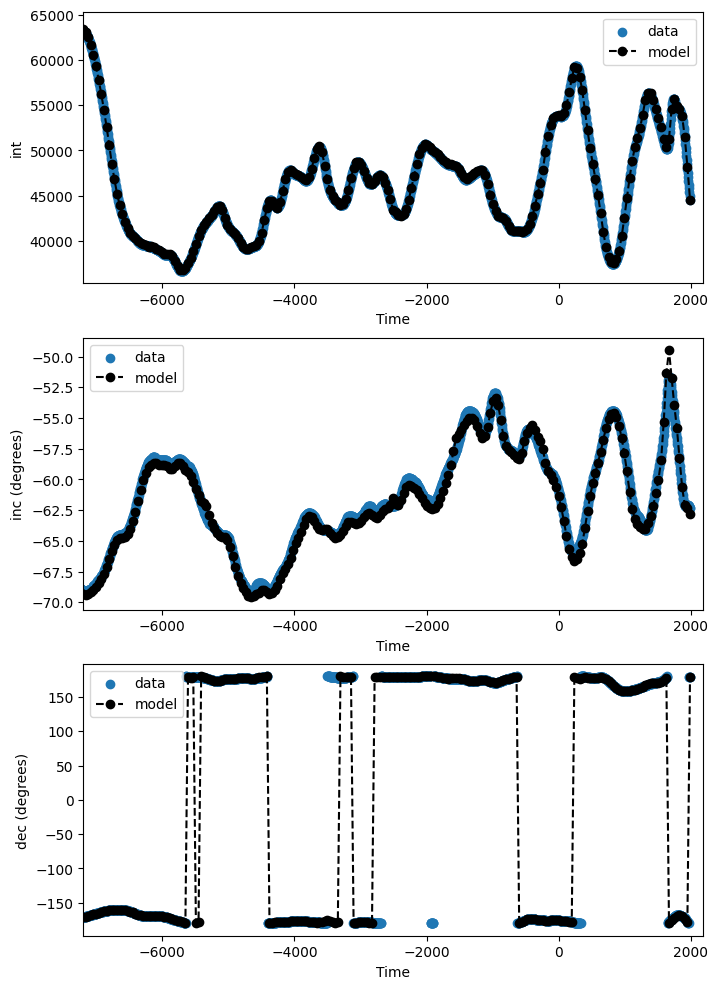

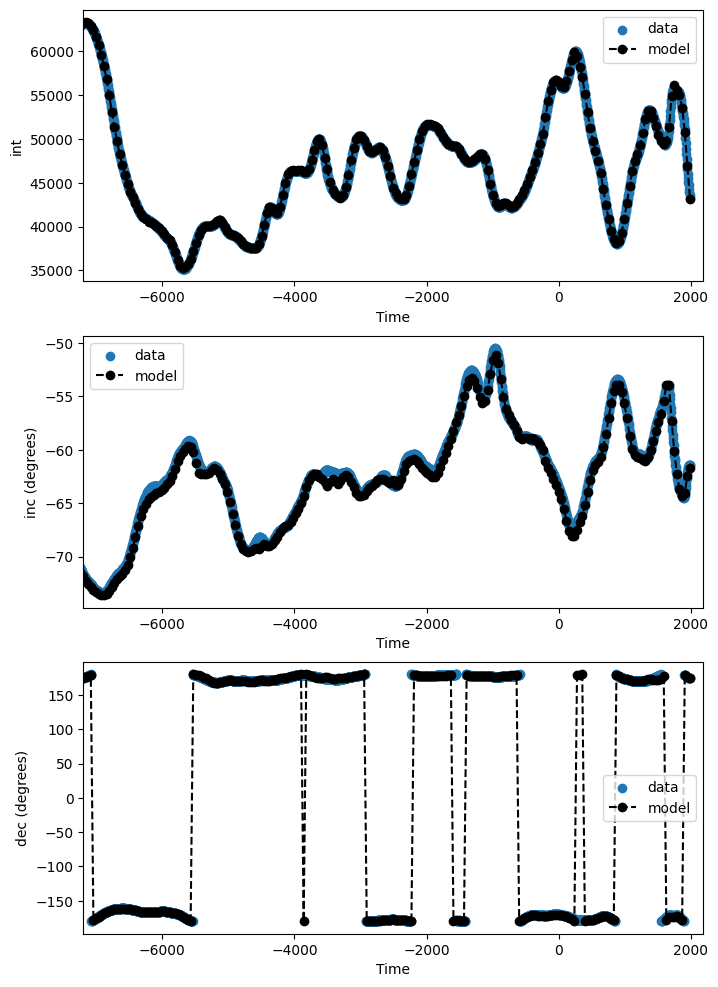

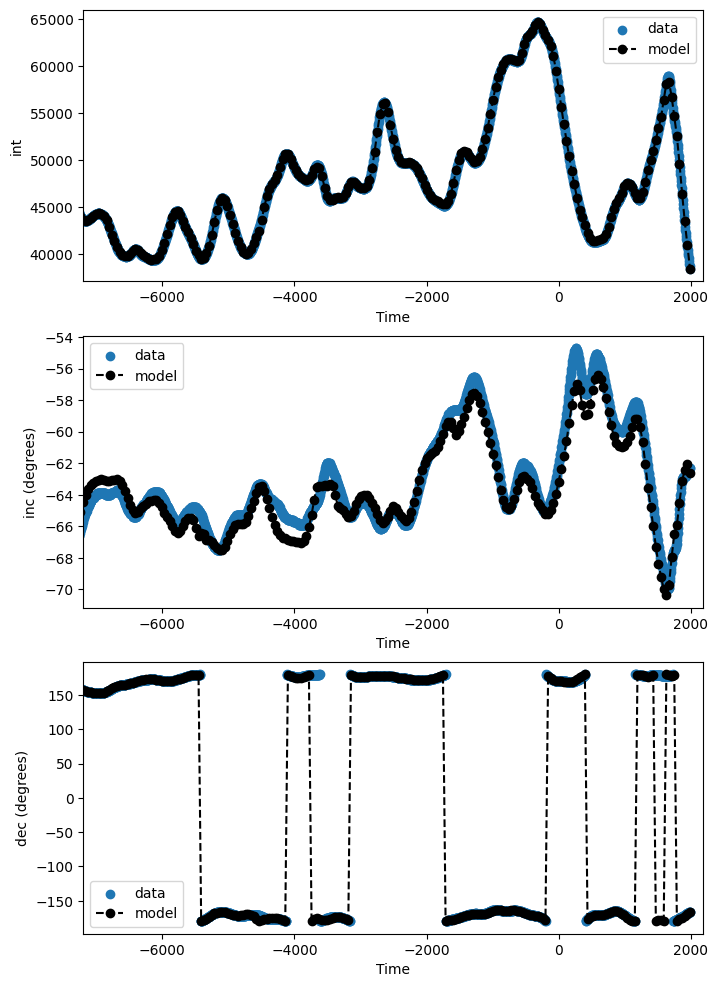

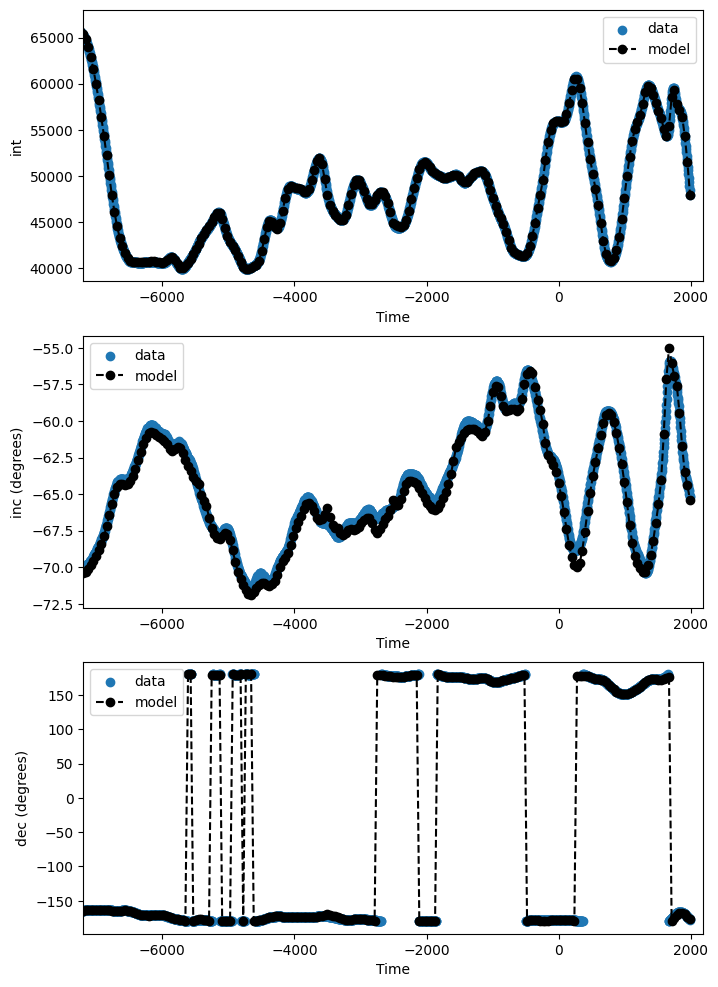

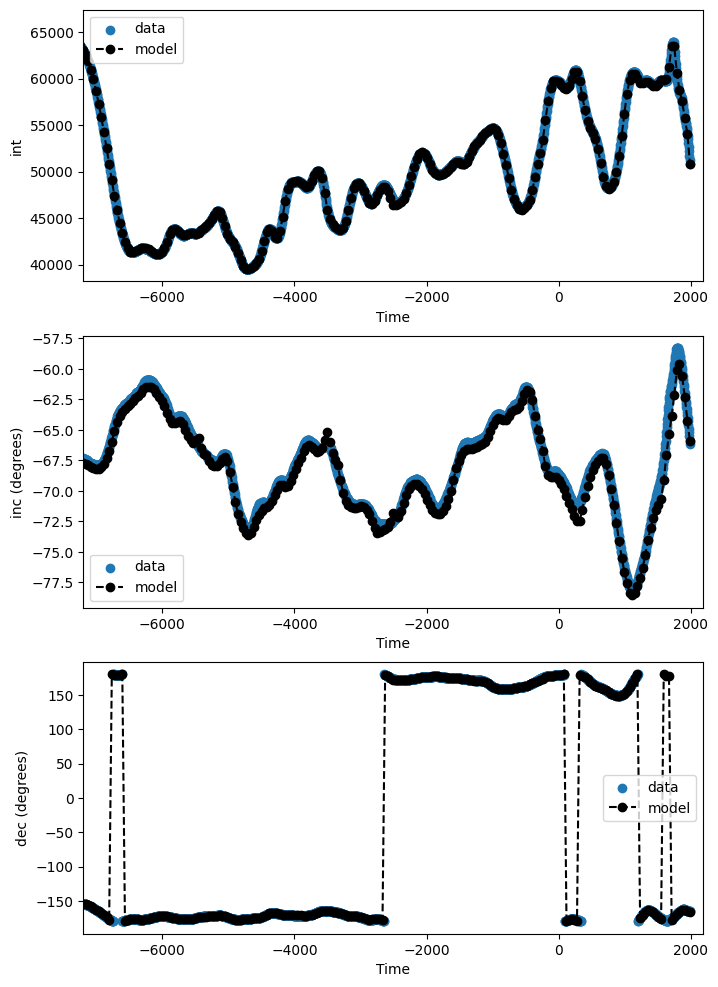

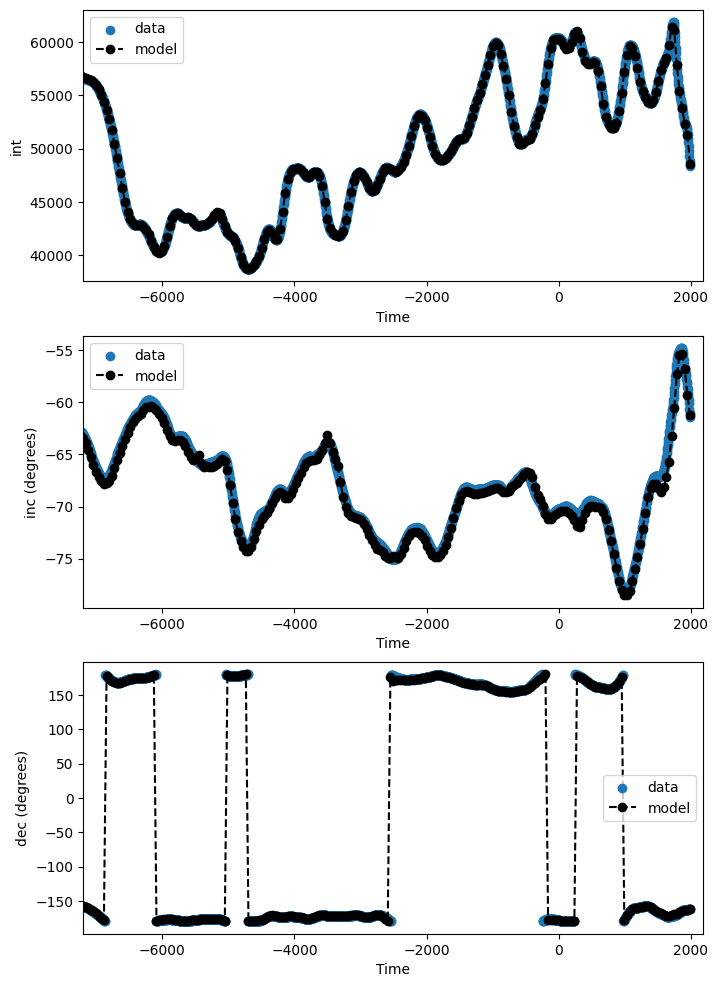

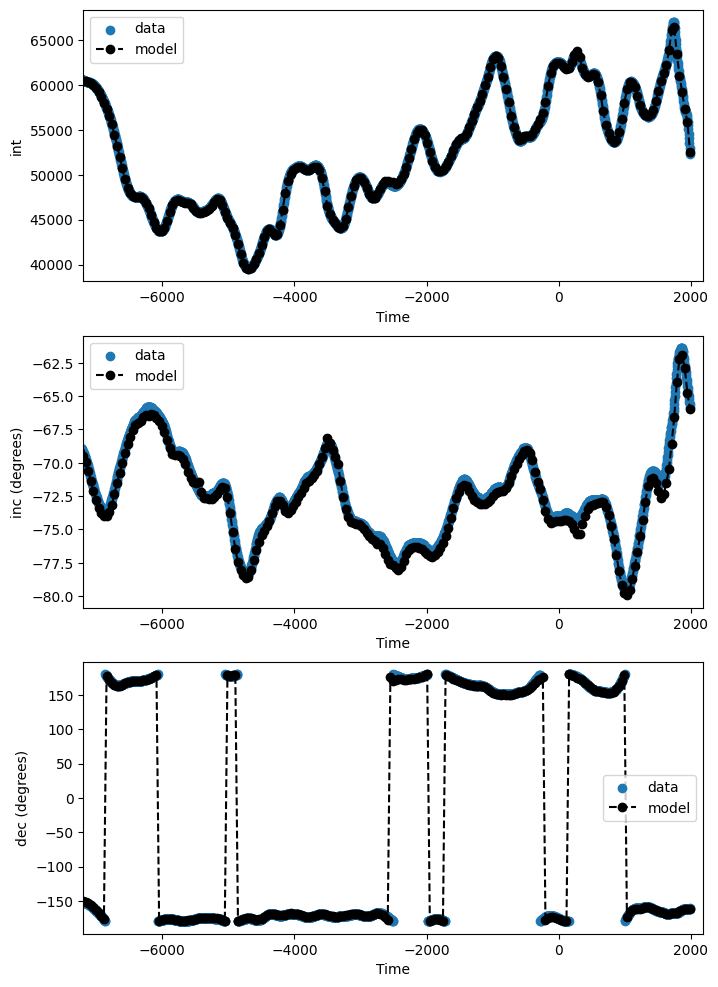

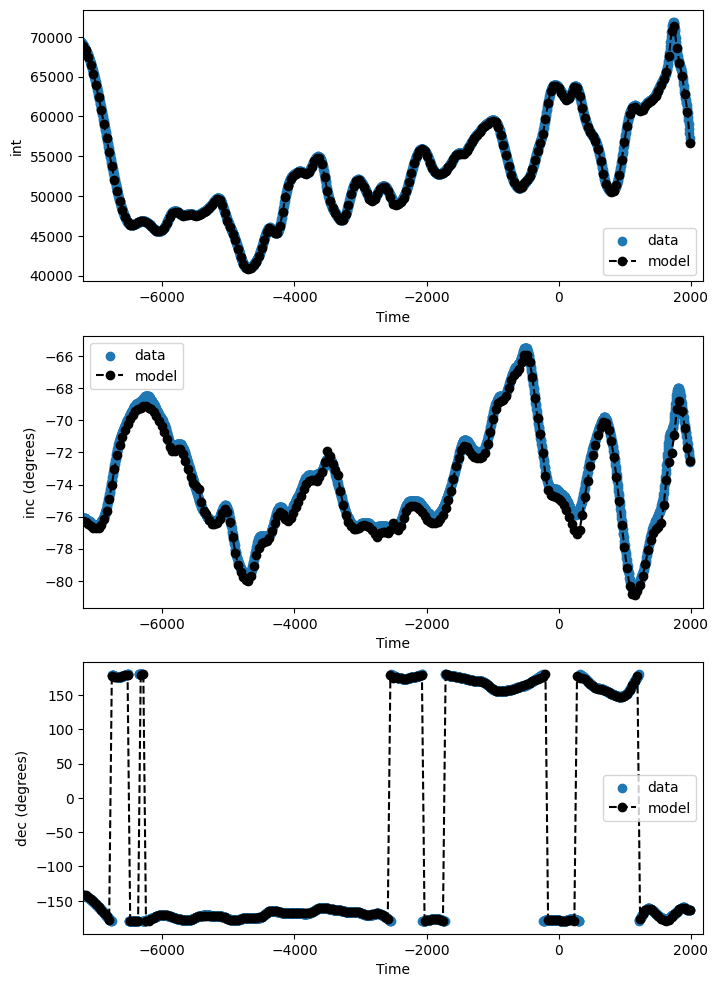

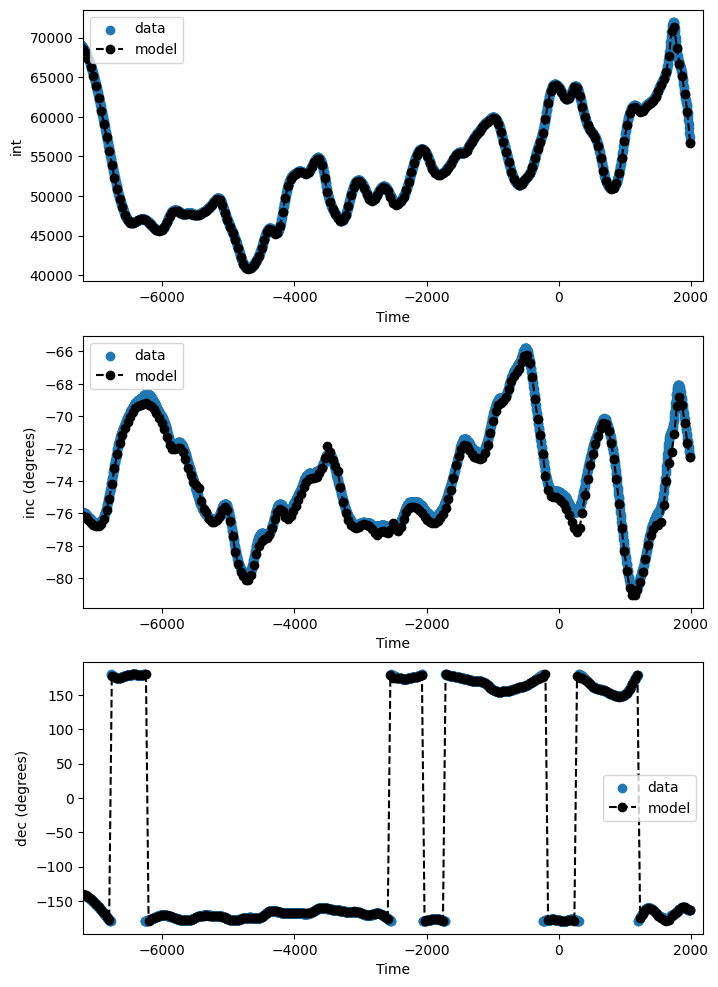

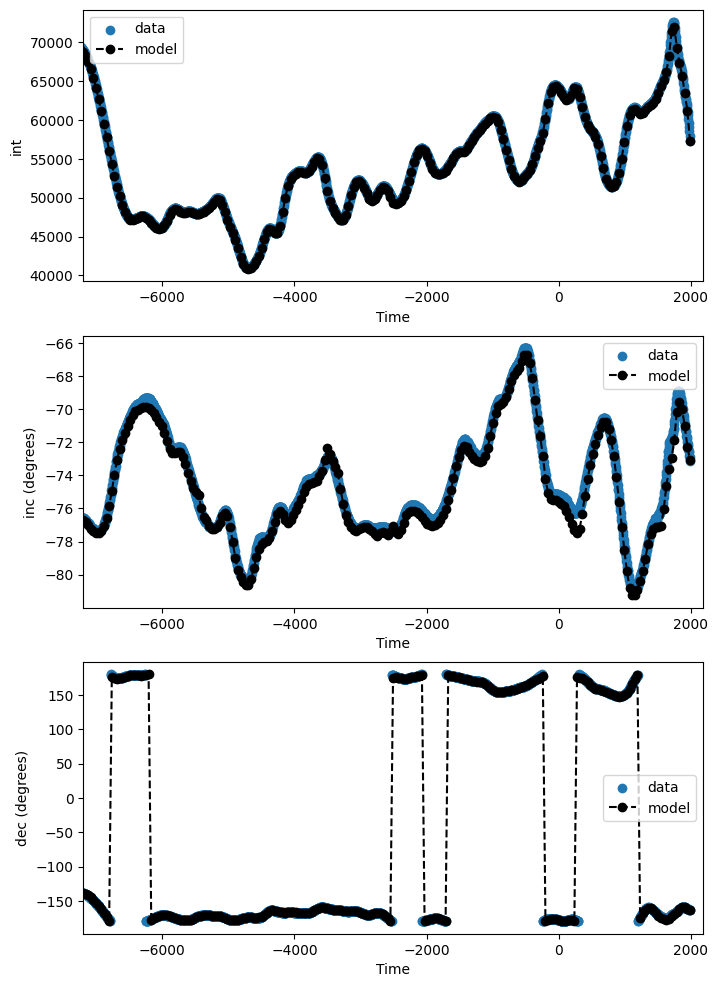

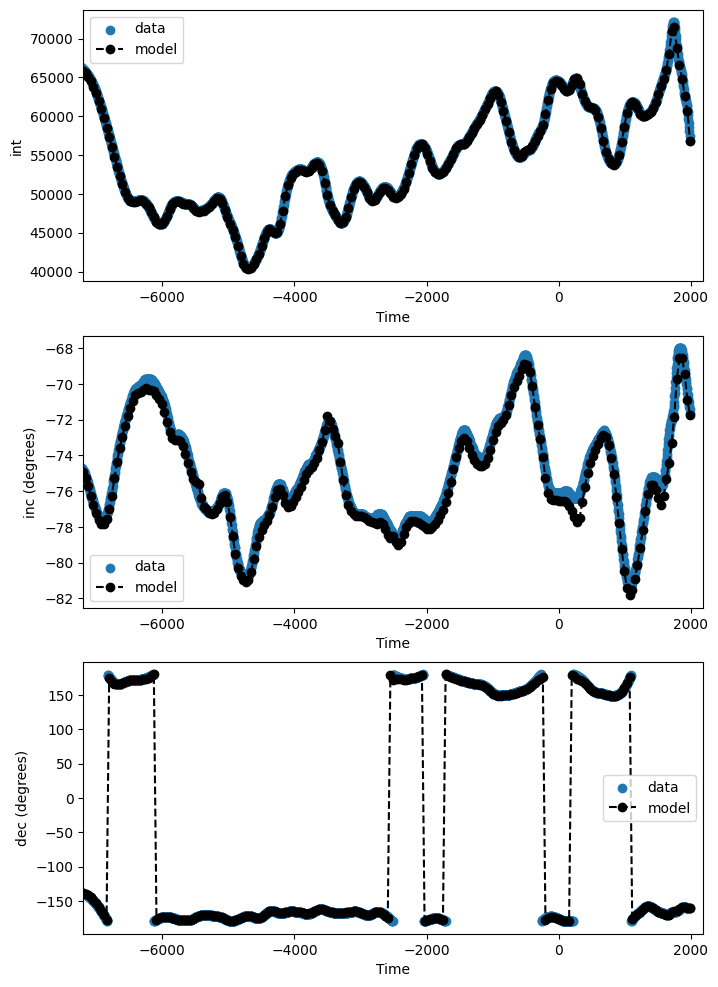

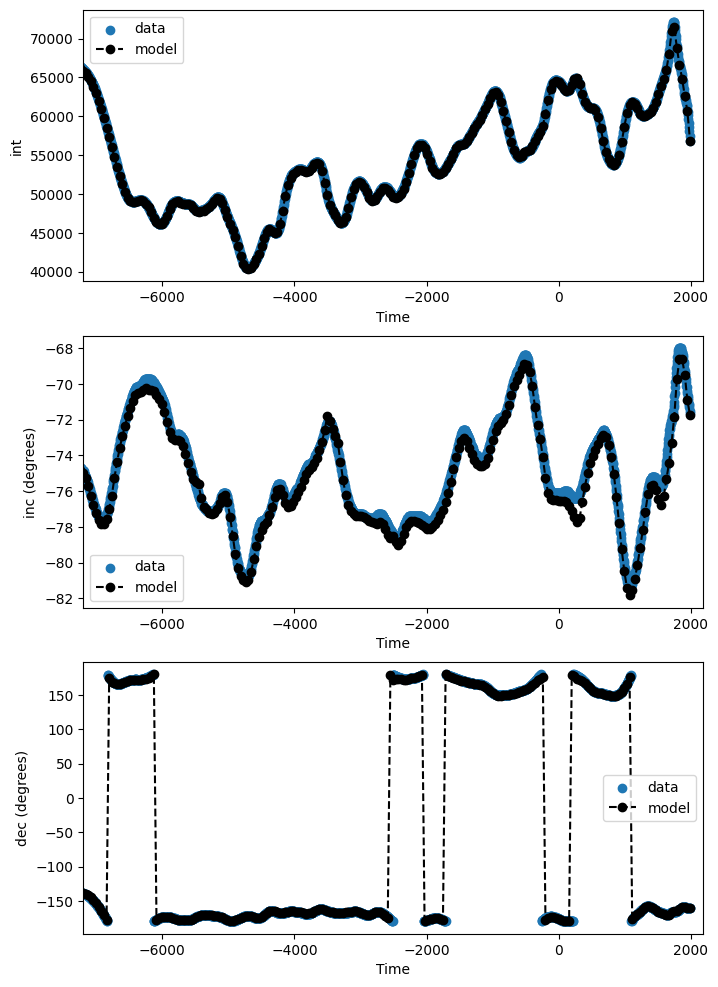

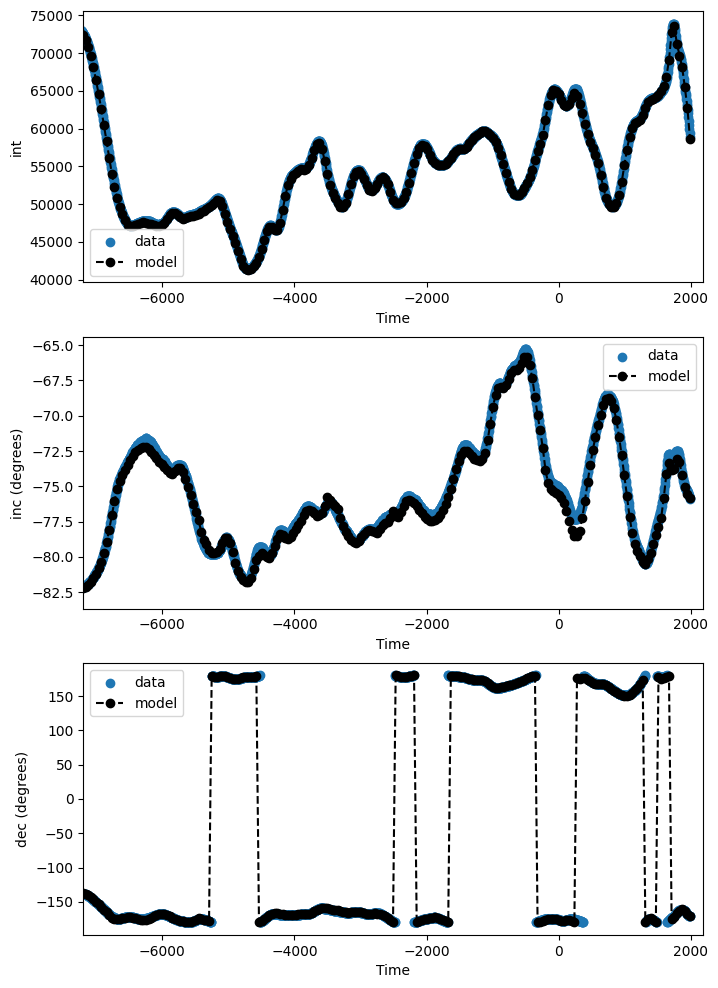

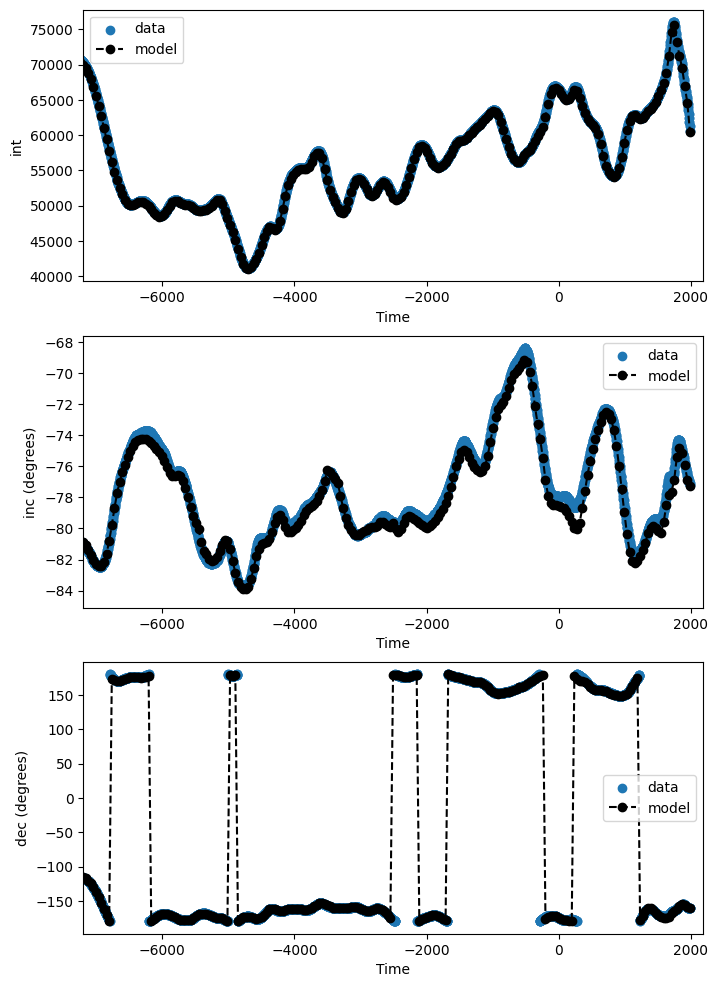

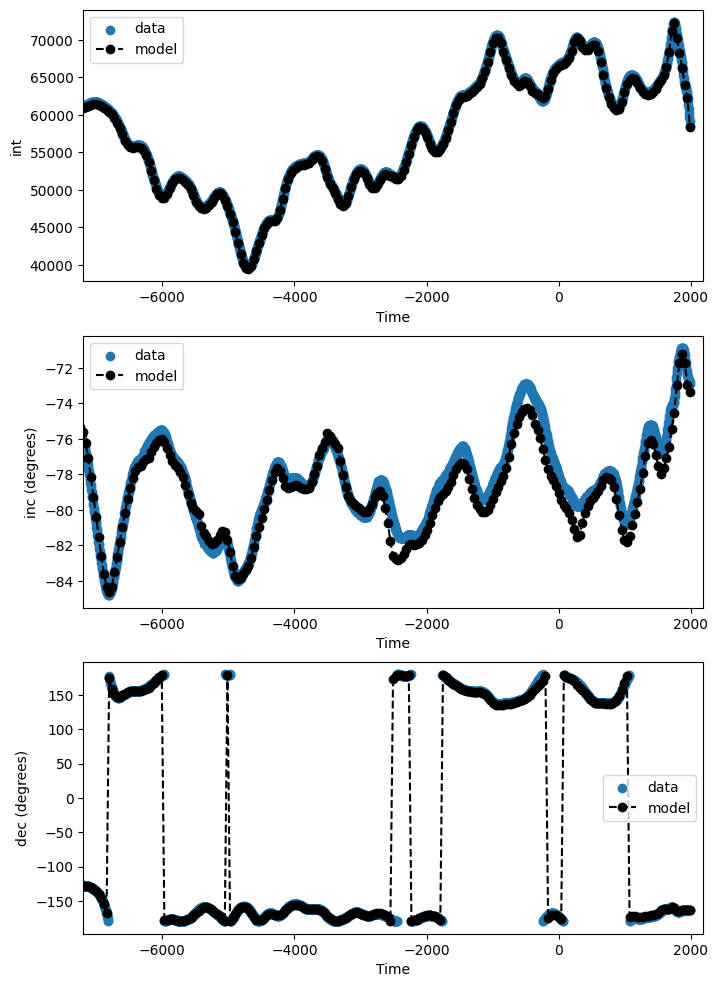

In [14]:
# write a loop to observe the fit for all stations
for station in stationlist:
    fig, axes = plt.subplots(len(station.types), 1, figsize=(8, 4*len(station.types)))
    axes = plot_tools.compare_loc(axes, test_inv, station)
    plt.show()

#### forward calculations
After calculation of the gaussian coefficients, we plot their effect on a worldmap and on one location. For the worldmap, we define 3 axes and choose a projection. We choose a time we want to plot and indicate if we want to plot the magnetic field at the cmb (`cmb=True`) or not (default).

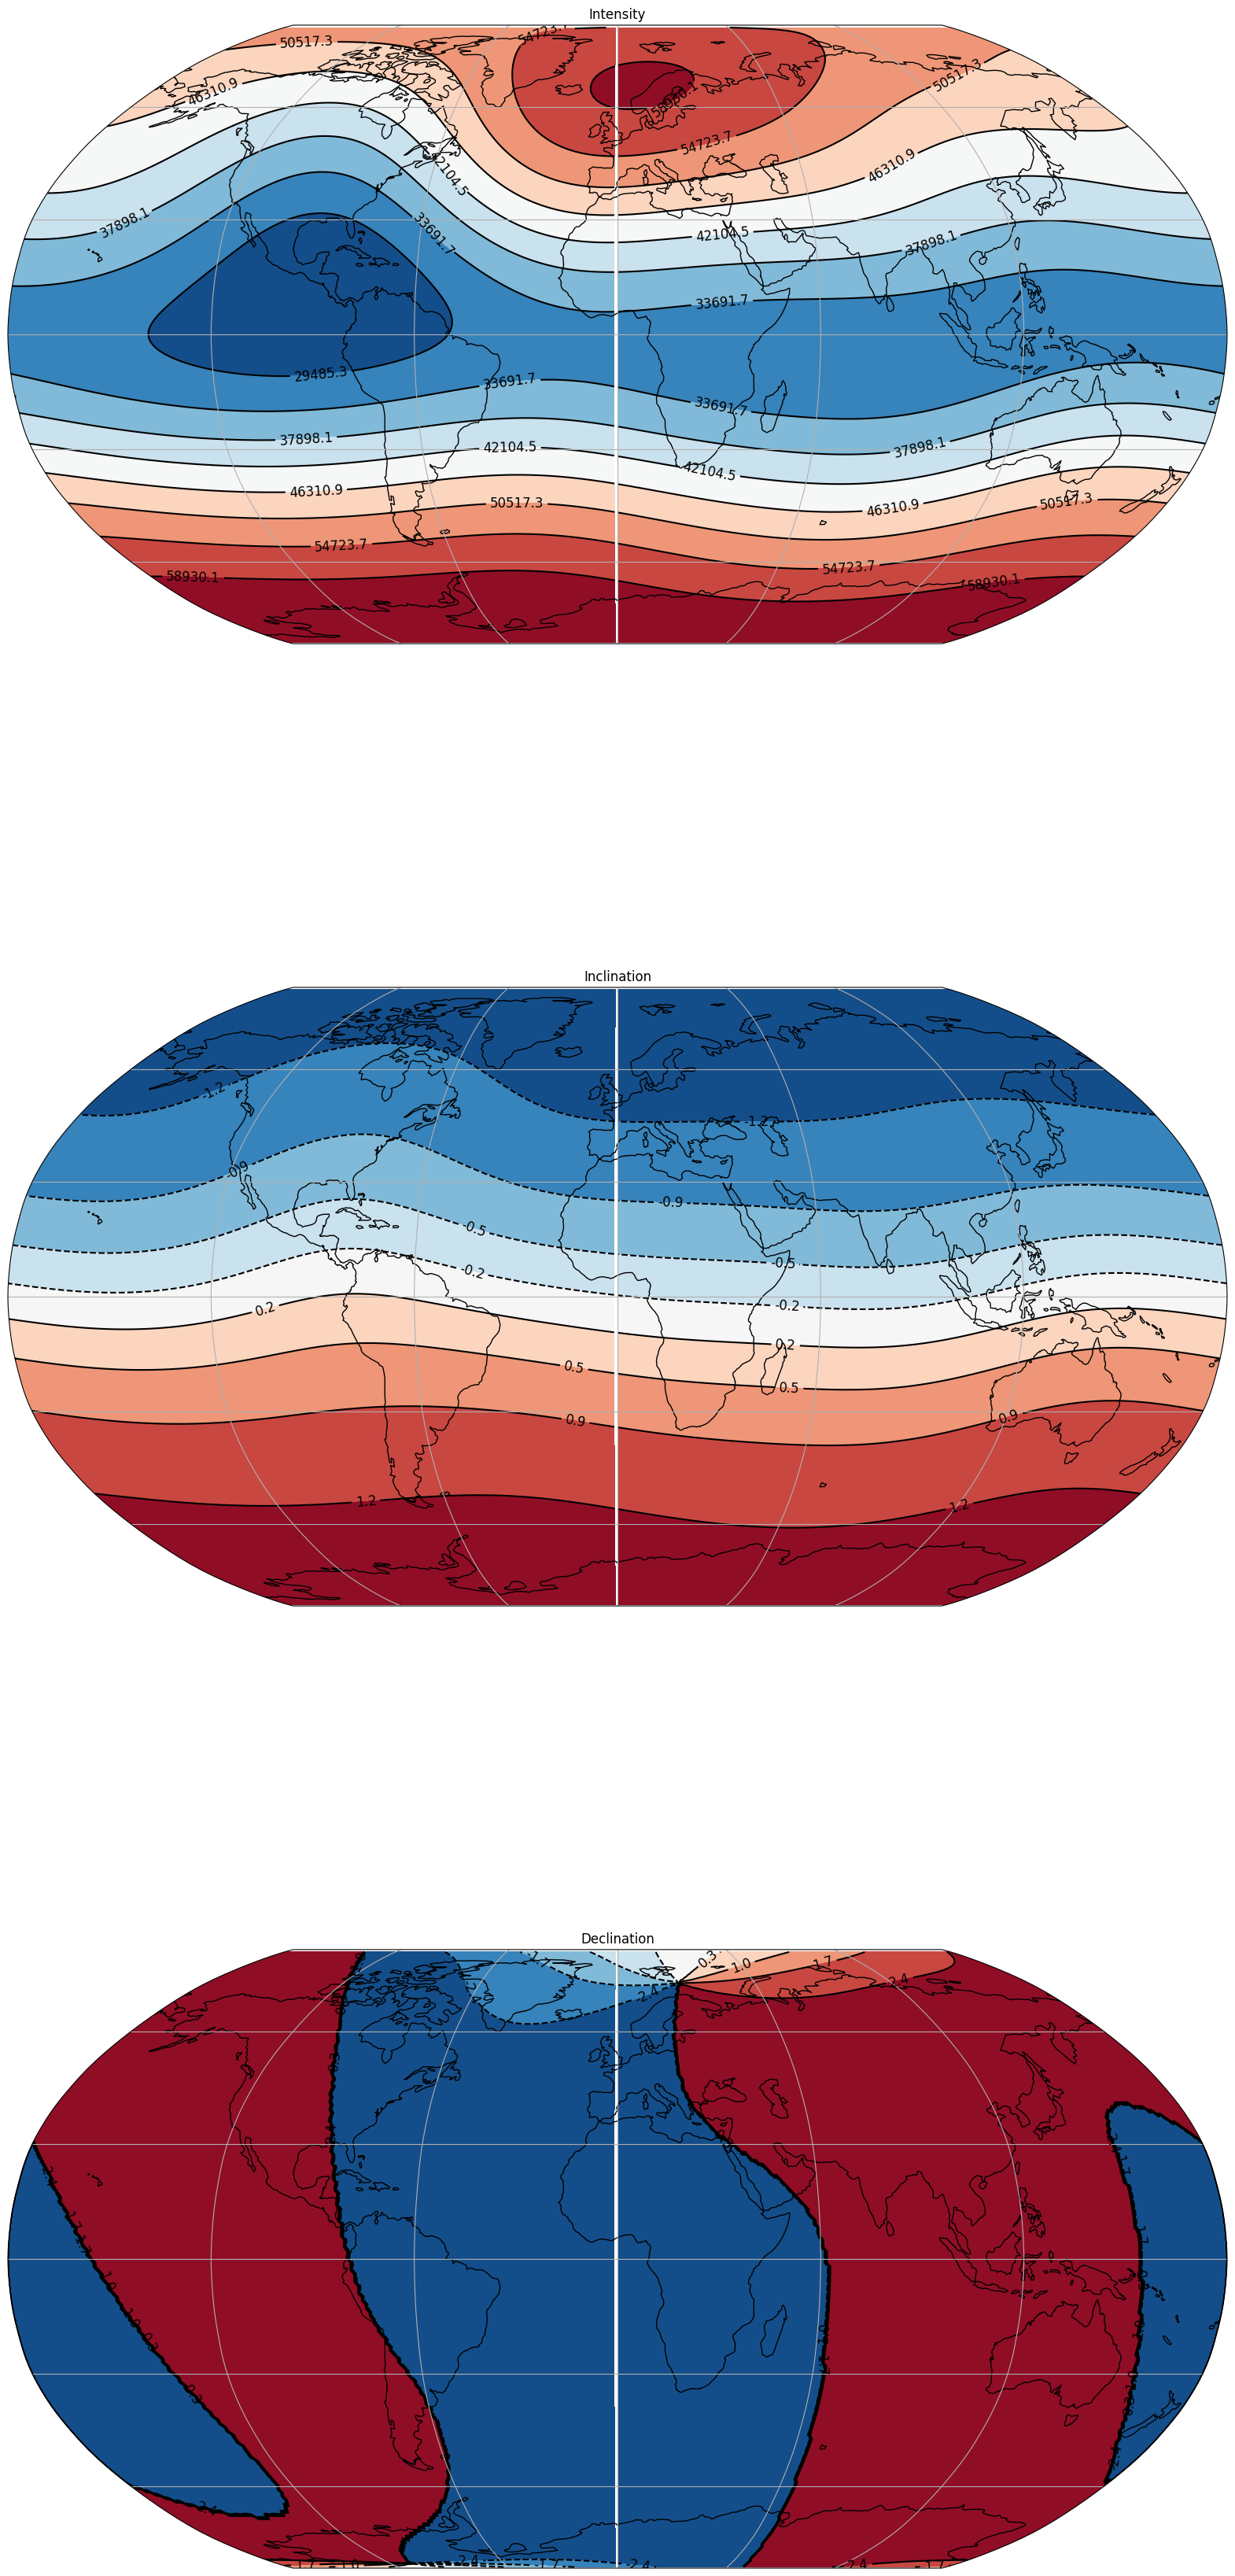

In [15]:
# set three axes and apply a Robinson world projection
fig, axes = plt.subplots(nrows=3, figsize=(20, 45), subplot_kw={'projection': ccrs.Robinson()})
# call the function; input axes and inversion class, but also wished projection, plot time, and optional plotting keywords
axes = plot_tools.plot_world(axes, test_inv, proj=ccrs.PlateCarree(), time=-8000)
plt.show()

In [16]:
# clear memory and delete instance of class
del test_inv

## 3. Sweeping through models to find optimal damping parameters (optional)
Normally we do not have the optimal damping parameters yet, which is why we will have to search for them **now**. 
We will start a new class and add all our data, then we will sweep through a range of spatial and temporal damping parameters. By plotting model size versus residuals, we will find the best fitting parameters.

In [17]:
# set class and add data
sweep_inv = FieldInversion(time_array = np.linspace(-8000, 1990, 252), maxdegree=10)
for station in stationlist:
    sweep_inv.add_data(station)

#### *sweep_damping*
This method enables us to sweep through the parameters, it needs:
- `spatial_range`: the range of spatial damping parameters to be tested
- `temporal_range`: the range of temporal damping parameters to be tested
- `x0`: starting model of gaussian coefficients

Results will be saved to the path specified by `basedir`. We will use 10 iterations per inversion.

In [18]:
spatial_range = np.logspace(-15, -11, 5)
temporal_range = np.logspace(-4, 0, 5)
x0 = np.zeros(sweep_inv._nm_total)
x0[0] = 30000

sweep_inv.sweep_damping(x0, spatial_range, temporal_range, basedir= path / 'output', max_iter=10)

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.


 20%|████████████████▊                                                                   | 1/5 [03:14<12:58, 194.53s/it]

The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.


 40%|█████████████████████████████████▌                                                  | 2/5 [06:40<10:03, 201.12s/it]

The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [09:47<06:29, 194.94s/it]

The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [12:47<03:08, 188.92s/it]

The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.
The spherical order of the model is too high (variables: 120 vs data: 108), decrease maxdegree to a lower value.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [15:48<00:00, 189.63s/it]


After performing the calculations, we can plot the results of the damping parameters with `plot_tools.plot_sweep`. The best model would be the model that produces a low residual and a small model size (=norm of the gaussian coefficients).

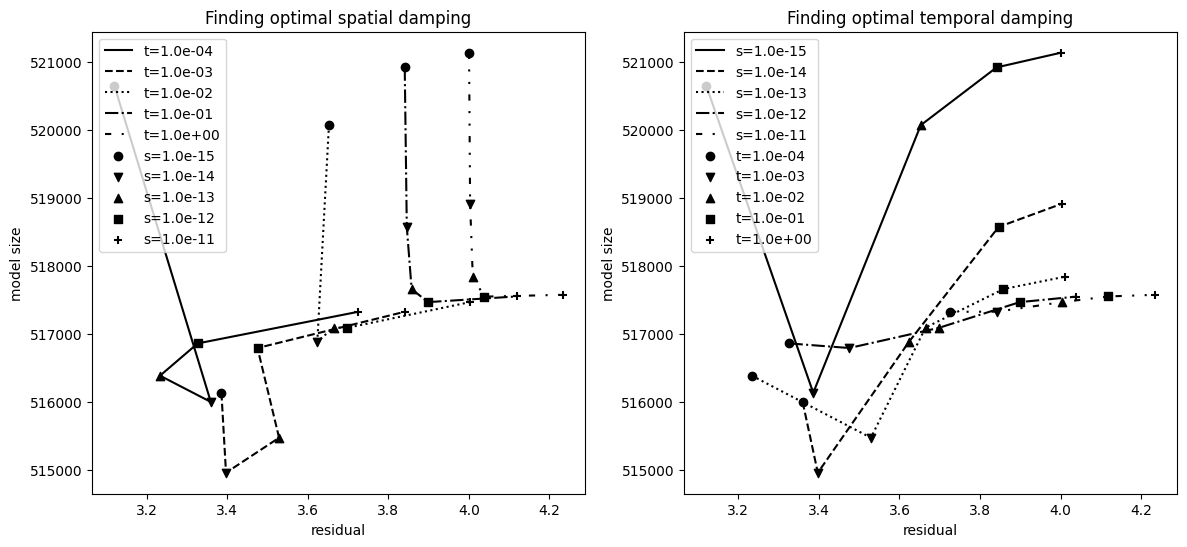

In [19]:
# Now we plot residual vs norm of the model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('Finding optimal spatial damping')
axes[1].set_title('Finding optimal temporal damping')
# call function to plot lines
axes = plot_tools.plot_sweep(axes, spatial_range, temporal_range, basedir=path / 'output')
axes[0].legend()
axes[1].legend()
# define colors and a colorbar
plt.show()

#### conclusion
A spatial damping factor between 1e-13 and 1e-14 seems to be best; it results in both a low residual and small Gauss coefficients, so our initial assumption of 5e-13 was good enough. For the temporal damping factor, a damping factor of around 1e-3 seems optimal. We previously used 1e-1, so we could make our main model (see Section 2) even better!

In [20]:
# delete class
del sweep_inv

## 4. Starting a model at one timestep (optional)
Instead of a time-dependent mode, you can also run a model at one specific timestep. However, damping is not possible for this kind of models and many `plot_tools` cannot be used with this class.

We start by loading `FieldInversionNoTime` and adding our previously used data. However, now we have to specify at which specific moment in time we want to model. We choose 3000 BC and set `time=-3000`.

In [21]:
# first import the required class
from geomagnetic_field_inversions.tools import FieldInversionNoTime

In [22]:
onetime_inv = FieldInversionNoTime(time=-3000, maxdegree=6)
for station in stationlist:
    onetime_inv.add_data(station)

Now we can prepare the matrix, run the inversion, and save it. Remember that we cannot impose any damping constraints.

In [23]:
onetime_inv.prepare_inversion()

x0 = np.zeros(onetime_inv._nm_total)
x0[0] = 30000
onetime_inv.run_inversion(x0, max_iter=20)
onetime_inv.save_coefficients(path / 'output')

We will plot the residuals per iteration to check whether enough iterations were used.

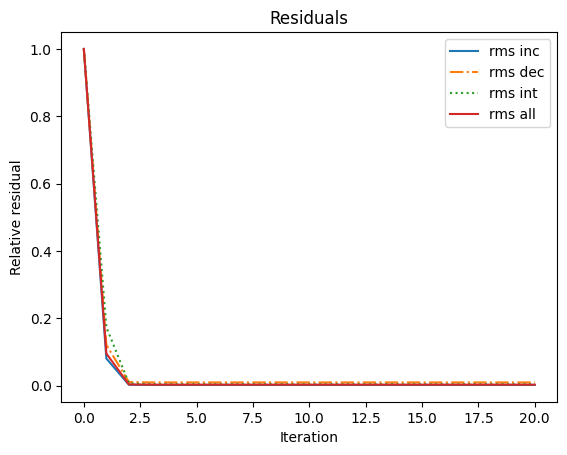

In [24]:
# start a figure
fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative residual')
# make a call to the plotting library, input ax and our FieldInversion instance
ax = plot_tools.plot_residuals(ax, onetime_inv)
ax.legend(loc='upper right')
plt.show()

3 iterations are enough to obtain stable residual, to be sure we can also plot the Gauss coefficients of order 1 per iteration by calling `plot_tools.plot_coeff` with `plot_iter=True`.

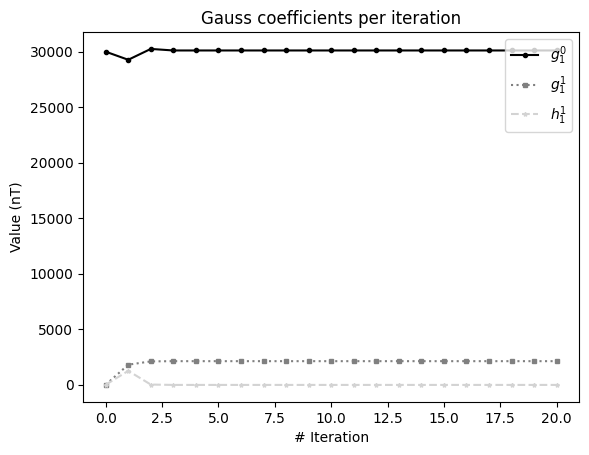

In [25]:
fig, ax = plt.subplots()
ax.set_title('Gauss coefficients per iteration')
ax.set_xlabel('# Iteration')
ax.set_ylabel('Value (nT)')
# we only want to plot gaussian coefficients of degree 1
ax = plot_tools.plot_coeff(ax, onetime_inv, degree=1, plot_iter=True)
ax.legend(loc='upper right')
plt.show()

This plot also shows that after 3 iterations we have obtained stable Gauss coefficients.

Finally we can create a worldmap by calling `plot_tools.plot_world` with `time=None`:

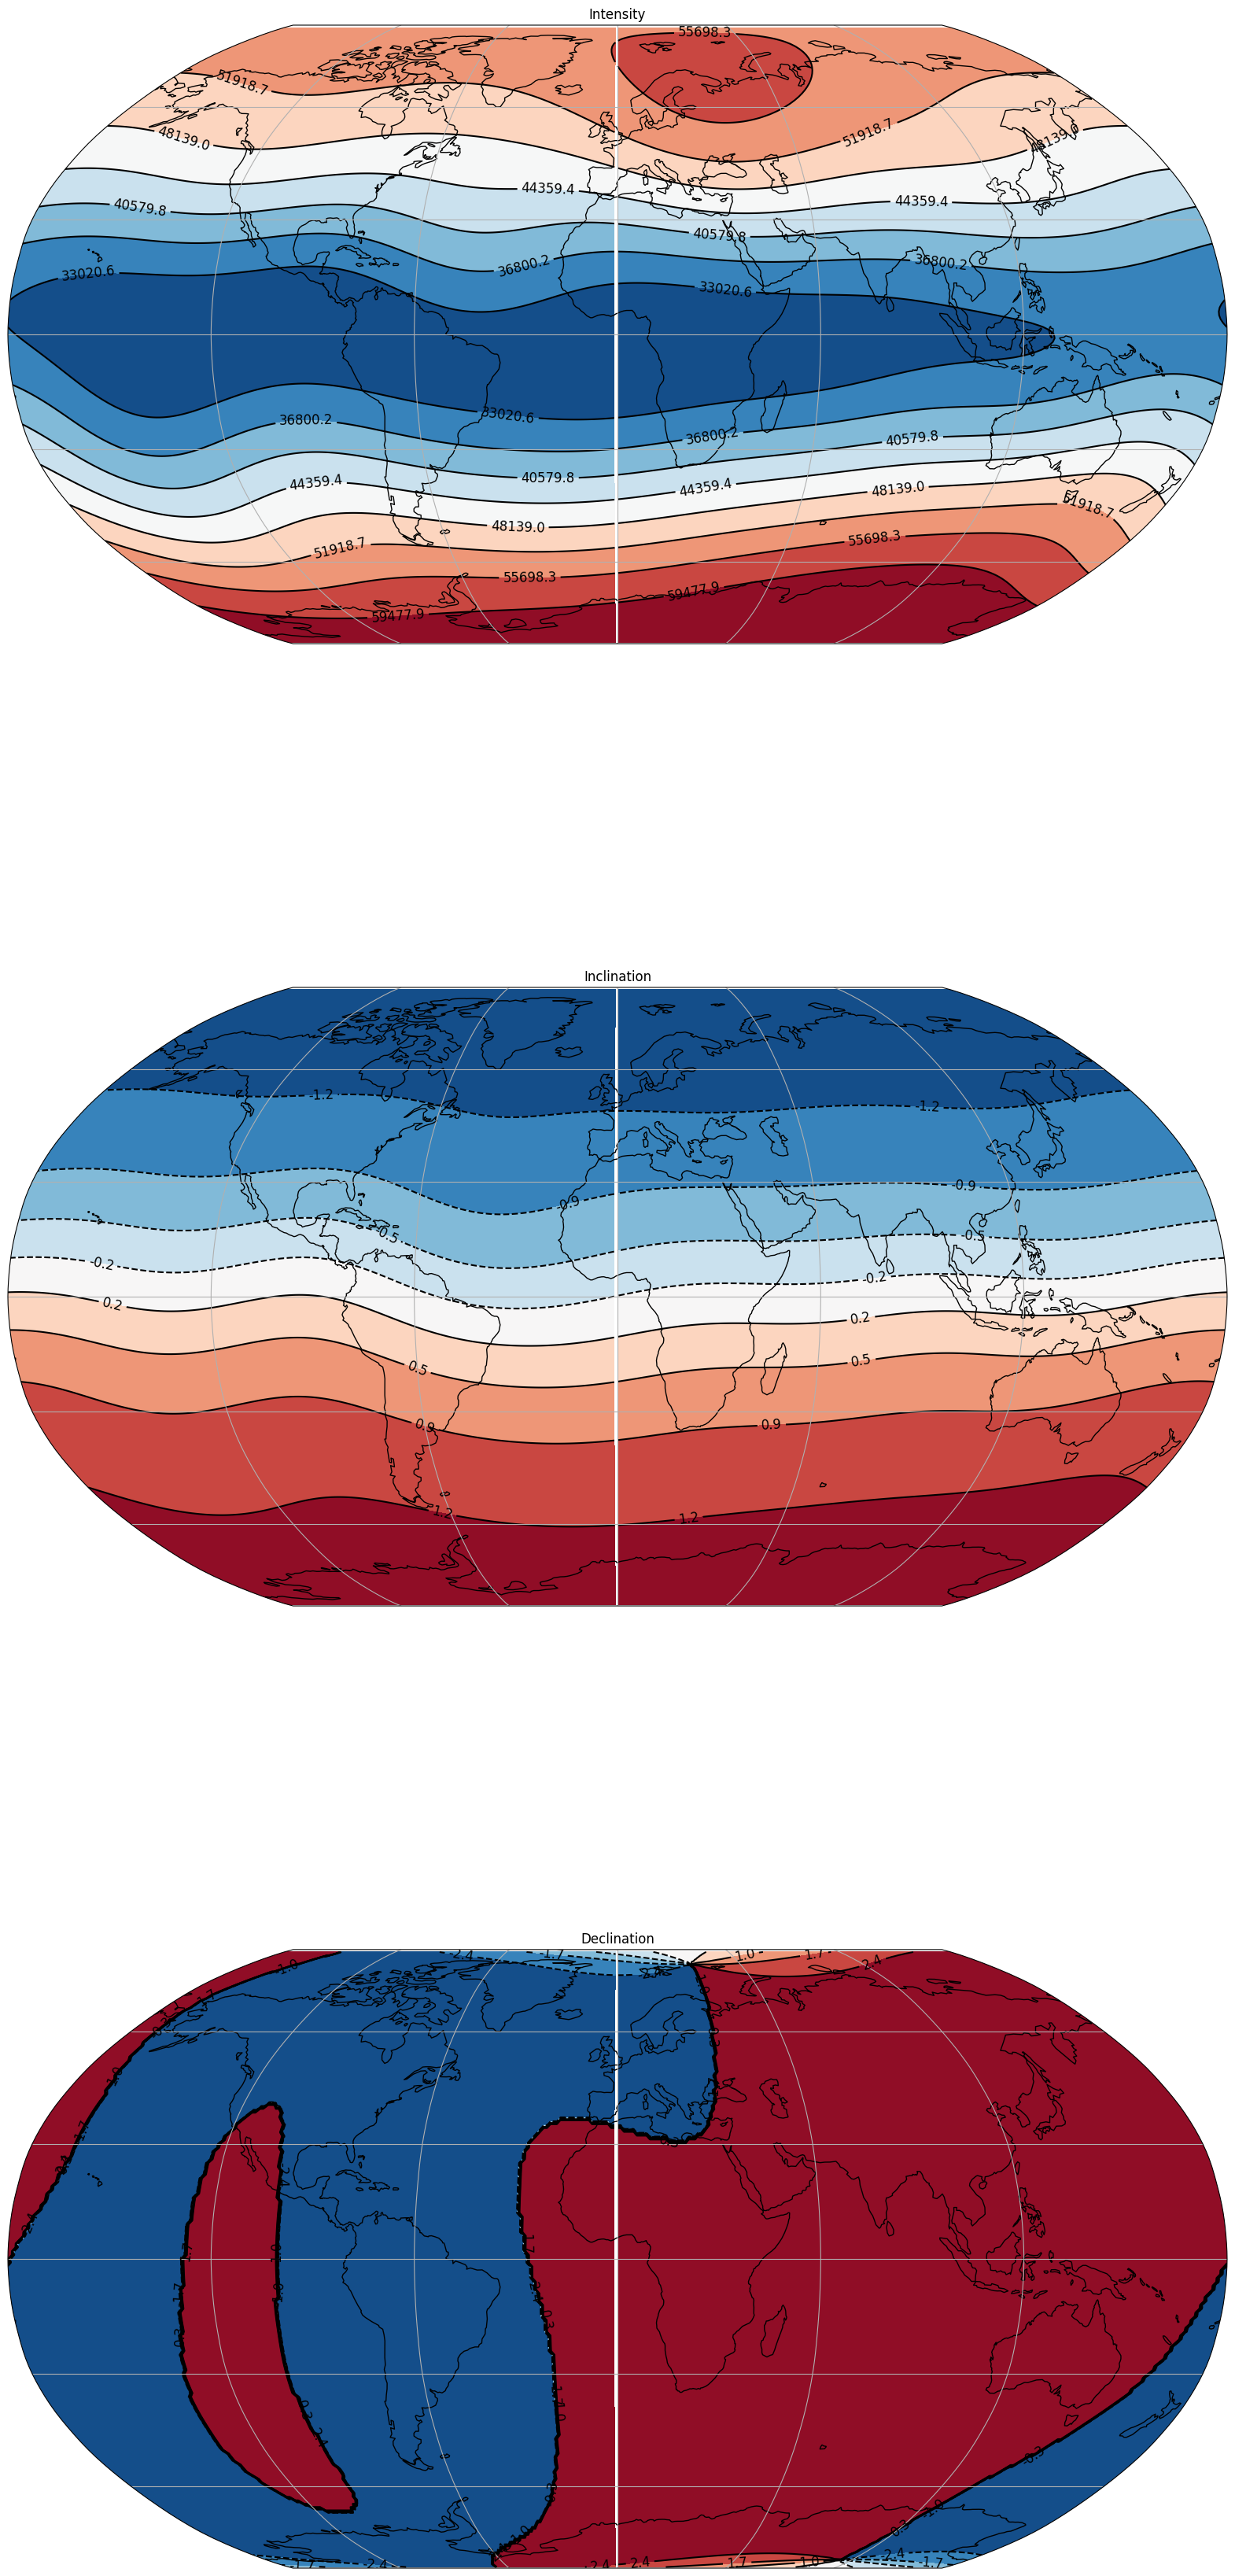

In [26]:
# set three axes and apply a Robinson world projection
fig, axes = plt.subplots(nrows=3, figsize=(20, 45), subplot_kw={'projection': ccrs.Robinson()})
# call the function; input axes and inversion class, but also wished projection, and optional plotting keywords
axes = plot_tools.plot_world(axes, onetime_inv, proj=ccrs.PlateCarree(), time=None)
plt.show()

In [27]:
# remove the class
del onetime_inv

## 5. Loading data in a Korte et al. format (optional)
We will end this tutorial with showing how you can load data in the format frequently used for making geomagnetic field models. We have included a representative file (`revdata.dat`) in the *docs*-folder. It is ordered in the following way:

* The first line is the Fortran format description for the data lines.
* The second line contains the following three columns:
    - 1st element: the epoch of the following block in years
    - 2nd element: 1 indicating main field data (not used in python code)
    - 3rd element: number of lines to follow for that epoch
* Each line of data contains the following columns:
    - 1st element: time/age in years
    - 2nd to 4th element: latitude in degrees, longitude in degrees, altitude in metres (considered 0 for Earth’s surface)
    - 5th element: number of available field components (3 for these test case, but can also be 1 or 2)
    - 6th to 8th element: information about 1st available field component: data, uncertainty, component code
    - 9th to 11th element: same info about 2nd available component
    - 12th to 14th element: same info about 3rd available component

the component code is as follows:
* 1 = magnetic x component
* 2 = magnetic y component
* 3 = magnetic z component
* 4 = magnetic horizontal component
* 5 = magnetic intensity component
* 6 = magnetic inclination component
* 7 = magnetic declination component

We will now load this datafile into our code by calling `tools.read_data` which automatically transform this file into what we need for the model. The function required the path to your file and the name of the file. It will create a temporary file which is also deleted after the function has been executed. The function returns the unique coordinates of all station in the datafile and the magnetic data per location.

In [28]:
# first import the package
from geomagnetic_field_inversions.tools import read_data

In [29]:
# run the function
unique_coords, stations = read_data(path, 'revdata.dat')

In [30]:
# now we add the data to the StationData-class
stat_list = []  # start a list which will contain all StationData instances
# this will transform the component code into the correct datatype
typedict = [None, 'x', 'y', 'z', 'hor', 'int', 'inc', 'dec']

for i, station in enumerate(stations):
    name = f'Station {i}'  # we give the stations a name
    # initiate class with latitude, longitude, height, and name
    stat = StationData(lat=unique_coords[i, 0], lon=unique_coords[i, 1], height=unique_coords[i, 2], name=name)
    # add types one by one
    for types in station:
        stat.add_data(typedict[int(types[0, 3])], data=types[:, :2].T, time_factor=1, error=types[:, 2].flatten())

    # fit data
    stat.fitting()
    # append to list
    stat_list.append(stat)

Longitude changed from -74.40 to 285.60
Longitude changed from -91.40 to 268.60
Longitude changed from -73.10 to 286.90
Longitude changed from -57.60 to 302.40
Longitude changed from -57.60 to 302.40
Longitude changed from -10.20 to 349.80
Longitude changed from -10.40 to 349.60
Longitude changed from -9.90 to 350.10
Longitude changed from -24.20 to 335.80
Longitude changed from -45.60 to 314.40
Longitude changed from -48.50 to 311.50
Longitude changed from -22.00 to 338.00
Longitude changed from -23.60 to 336.40
Longitude changed from -24.10 to 335.90
Longitude changed from -37.50 to 322.50
Longitude changed from -37.40 to 322.60
Longitude changed from -4.00 to 356.00
Longitude changed from -21.80 to 338.20
Longitude changed from -64.70 to 295.30


With this dataformat loaded you could now proceed as usual to initiating a `FieldInversion`-instance (see Section 2).

In [31]:
dataformat_inv = FieldInversion(time_array = np.linspace(-8000, 1990, 252), maxdegree=10, verbose=True)
for station in stat_list:
    dataformat_inv.add_data(station)

Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 0 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 1 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 2 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 3 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 4 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordinates.
Data of Station 5 is added to class
Adding int-type
Adding inc-type
Adding dec-type
Coordinates are geodetic, translating to geocentric coordi

In [32]:
# clear class
del dataformat_inv

## end of tutorial
This is the end of this tutorial, but we have not covered every detail. If you want to know more about a function, have a look at the code, or type the function with a questionmark after it to get more info (e.g. `plot_tools.plot_spectrum?`). Otherwise you can allways drop an email to Frenk Out at f.out@uu.nl or outfrenk@gmail.com.